# Benchmark of the clustering + smoothing method

Our goal is to verify that our clustering and smoothing methods are working in a meaningful way. To measure this, we will take the CryptoBench test fold (set) and for each of the apo structures, we will check for existence of a cluster against the real cryptic binding site.

To do so, we will need to:
- predict the scores using the CryptoBench method
- cluster the residues by given metrics
- smoothen the clusters as in `smoothing/predict_single.ipynb`
- compare the predicted and smoothened clusters with the actual cryptic binding sites

Note that you will need to update the paths to the models and other data to run this notebook yourself.
Also, using GPU is highly recommended.

In [1]:
### PREDICTION SOURCE CODE ###

import torch
from transformers import AutoTokenizer, EsmModel
import numpy as np
import torch.nn as nn
import os

torch.manual_seed(420)

ESM_MODEL_NAME = "facebook/esm2_t36_3B_UR50D"
MAX_LENGTH = 1024
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
OUTPUT_SIZE = 1
DROPOUT = 0.25
SEQUENCE_MAX_LENGTH = MAX_LENGTH - 2
# download: https://owncloud.cesnet.cz/index.php/s/mPo9NCWMBouwVAo/download
MODEL_PATH = "/home/skrhakv/cryptic-nn/final-data/trained-models/multitask-finetuned-model-with-ligysis.pt"


class FinetuneESM(nn.Module):
    def __init__(self, esm_model: str) -> None:
        super().__init__()
        self.llm = EsmModel.from_pretrained(esm_model)
        self.dropout = nn.Dropout(DROPOUT)
        self.classifier = nn.Linear(self.llm.config.hidden_size, OUTPUT_SIZE)
        self.plDDT_regressor = nn.Linear(self.llm.config.hidden_size, OUTPUT_SIZE)
        self.distance_regressor = nn.Linear(self.llm.config.hidden_size, OUTPUT_SIZE)

    def forward(self, batch: dict[str, np.ndarray]) -> tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        input_ids, attention_mask = batch["input_ids"], batch["attention_mask"]
        token_embeddings = self.llm(input_ids=input_ids, attention_mask=attention_mask).last_hidden_state

        return (
            self.classifier(token_embeddings),
            self.plDDT_regressor(token_embeddings),
            self.distance_regressor(token_embeddings),
        )


def compute_prediction(sequence: str, emb_path: str) -> np.ndarray:
    """
    Compute the residue-level prediction using the CryptoBench model.

    Args:
        sequence (str): Sequence of amino acids to be predicted.

    Returns:
        np.ndarray: The predicted scores for each residue.
    """
    model = torch.load(MODEL_PATH, map_location=DEVICE, weights_only=False)

    tokenizer = AutoTokenizer.from_pretrained(ESM_MODEL_NAME)
    model.eval()

    KRAS_sequence = str(sequence)
    all_embeddings = []
    final_output = []

    # Process sequence in chunks of SEQUENCE_MAX_LENGTH
    for i in range(0, len(KRAS_sequence), SEQUENCE_MAX_LENGTH):
        processed_sequence = KRAS_sequence[i : i + SEQUENCE_MAX_LENGTH]

        tokenized = tokenizer(
            processed_sequence, max_length=MAX_LENGTH, padding="max_length", truncation=True, return_tensors="pt"
        )
        tokenized = {k: v.to(DEVICE) for k, v in tokenized.items()}

        # embeddings
        with torch.no_grad():
            llm_output = model.llm(input_ids=tokenized["input_ids"], attention_mask=tokenized["attention_mask"])
            embeddings = llm_output.last_hidden_state  # shape: (1, seq_len, hidden_dim)

        embeddings_np = embeddings.squeeze(0).detach().cpu().numpy()
        mask = tokenized["attention_mask"].squeeze(0).detach().cpu().numpy().astype(bool)
        embeddings_np = embeddings_np[mask][1:-1]  # exclude [CLS], [SEP]
        all_embeddings.append(embeddings_np)

        # prediction
        with torch.no_grad():
            output, _, _ = model(tokenized)

        output = output.squeeze(0)
        mask = tokenized["attention_mask"].squeeze(0).bool()
        output = output[mask][1:-1]  # exclude [CLS], [SEP]

        probabilities = torch.sigmoid(output).detach().cpu().numpy()
        final_output.extend(probabilities)

    # save the concatenated embeddings for the entire sequence
    final_embeddings = np.concatenate(all_embeddings, axis=0)
    save_path = os.path.join(emb_path)
    np.save(save_path, final_embeddings)

    return np.array(final_output).flatten()

In [2]:
### SMOOTHING SOURCE CODE ###

import torch
import numpy as np
import os

import torch.nn as nn

POSITIVE_DISTANCE_THRESHOLD = 15
NEGATIVE_DISTANCE_THRESHOLD = 10

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def process_single_sequence(structure_name: str, chain_id: str, binding_residues: list[str], sequence: str, embedding_path: str, distance_matrix: np.ndarray):
    id = structure_name.lower() + chain_id
    if not os.path.exists(embedding_path):
        raise FileNotFoundError(f'Embedding file for {id} not found in {embedding_path}')
    
    embedding = np.load(embedding_path)

    Xs = []
    Ys = []
    idx = []

    binding_residues_indices = [int(residue[1:]) for residue in binding_residues]
    
    negative_examples_indices = set()
    
    for (aa, residue_idx) in [(residue[0], int(residue[1:])) for residue in binding_residues]:
        assert sequence[residue_idx] == aa
        close_residues_indices = np.where(distance_matrix[residue_idx] < POSITIVE_DISTANCE_THRESHOLD)[0]
        close_binding_residues_indices = np.intersect1d(close_residues_indices, binding_residues_indices)
        
        concatenated_embedding = np.concatenate((embedding[residue_idx], np.mean(embedding[close_binding_residues_indices], axis=0)))
        Xs.append(concatenated_embedding)
        Ys.append(1)  # positive example
        idx.append(residue_idx)
        
        really_close_residues_indices = np.where(distance_matrix[residue_idx] < NEGATIVE_DISTANCE_THRESHOLD)[0]
        negative_examples_indices.update(set(list(really_close_residues_indices)) - set(list(binding_residues_indices)))

    for residue_idx in negative_examples_indices:
        close_residues_indices = np.where(distance_matrix[residue_idx] < POSITIVE_DISTANCE_THRESHOLD)[0]
        close_binding_residues_indices = np.intersect1d(close_residues_indices, binding_residues_indices)
        concatenated_embedding = np.concatenate((embedding[residue_idx], np.mean(embedding[close_binding_residues_indices], axis=0)))
        Xs.append(concatenated_embedding)
        Ys.append(0)
        idx.append(residue_idx)

    return np.array(Xs), np.array(Ys), np.array(idx)

def predict_single_sequence(Xs, Ys, idx, model_3):
    Xs = torch.tensor(Xs, dtype=torch.float32).to(device)
    Ys = torch.tensor(Ys, dtype=torch.int64).to(device)
    idx = torch.tensor(idx, dtype=torch.int64).to(device)

    test_logits = model_3(Xs).squeeze()
    test_pred = torch.sigmoid(test_logits)

    return {'predictions': test_pred.detach().cpu().numpy(), 'indices': idx.detach().cpu().numpy()}

DROPOUT = 0.5
LAYER_WIDTH = 2048
ESM2_DIM = 2560
INPUT_DIM  = ESM2_DIM * 2

class CryptoBenchClassifier(nn.Module):
    def __init__(self, dim=LAYER_WIDTH, dropout=DROPOUT):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=INPUT_DIM, out_features=dim)
        self.dropout1 = nn.Dropout(dropout)

        self.layer_2 = nn.Linear(in_features=dim, out_features=dim)
        self.dropout2 = nn.Dropout(dropout)

        self.layer_3 = nn.Linear(in_features=dim, out_features=1)

        self.relu = nn.ReLU()

    def forward(self, x):
      # Intersperse the ReLU activation function between layers
       return self.layer_3(self.dropout2(self.relu(self.layer_2(self.dropout1(self.relu(self.layer_1(x)))))))


In [ ]:
### UTILITIES ###

def compute_distance_matrix(coordinates: np.ndarray) -> np.ndarray:
    """
    Compute the pairwise distance matrix for a given set of coordinates.

    Args:
        coordinates (np.ndarray): A 2D array of shape (N, 3), where N is the number of points,
                                   and each row represents the (x, y, z) coordinates of a point.

    Returns:
        np.ndarray: A 2D array of shape (N, N), where the element at [i, j] represents the Euclidean
                    distance between the i-th and j-th points.
    """
    coordinates = np.array(coordinates)
    distance_matrix = np.linalg.norm(coordinates[:, np.newaxis] - coordinates[np.newaxis, :], axis=-1)
    return distance_matrix

def pockets_overlap(pocket1: tuple[str, ...], pocket2: tuple[str, ...]) -> bool:
    """
    Determine if two pockets overlap based on their residue sets.

    Args:
        pocket1 (tuple[str, ...]): A tuple of residue identifiers for the first pocket.
        pocket2 (tuple[str, ...]): A tuple of residue identifiers for the second pocket.

    Returns:
        bool: True if the overlap ratio between the two pockets is greater than 0.5, False otherwise.
    """
    set1 = set(pocket1)
    set2 = set(pocket2)
    intersection = set1.intersection(set2)
    overlap_ratio = len(intersection) / min(len(set1), len(set2))
    return overlap_ratio > 0.5


def compute_center_distance(points: np.ndarray, expected_pocket_ids: list[int], actual_pocket_ids: list[int]) -> float:
    """
    Compute the distance from the predicted pocket center to the expected pocket center.

    Args:
        points (np.ndarray): Array of shape (N, 3) containing the coordinates of the points.
        expected_pocket_ids (list[int]): List of indices corresponding to the expected pocket.
        actual_pocket_ids (list[int]): List of indices corresponding to the predicted pocket.
    Returns:
        float: The DCC value, which is the distance from the predicted pocket center to the ligand center.
    """
    expected_coords = points[expected_pocket_ids].mean(axis=0)
    actual_coords = points[actual_pocket_ids].mean(axis=0)

    dist = np.linalg.norm(expected_coords - actual_coords)
    return dist

In [4]:
### CLUSTERING SOURCE CODE ###

import numpy as np
import torch
from sklearn.cluster import DBSCAN

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def compute_clusters(
    points: list[list[float]],
    prediction_scores: list[float],
    high_score_threshold: float = 0.7,
):
    """
    Compute clusters based on the given points and prediction scores.

    Args:
        points (list[list[float]]): A list of points, where each point is a list of 3 coordinates [x, y, z].
        prediction_scores (list[float]): A list of prediction scores corresponding to each point.

    Returns:
        np.ndarray: An array of cluster labels for each point. Points with no cluster are labeled as -1.
    """

    points_array = np.array(points)
    scores_array = np.array(prediction_scores).reshape(-1, 1)
    stacked = np.hstack((points_array, scores_array))  # Combine coordinates with scores

    high_score_mask = stacked[:, 3] > high_score_threshold

    high_score_points = stacked[high_score_mask][:, :3]  # Extract only (x, y, z) coordinates

    EPS = 5.0  # Max distance for neighbors
    MIN_SAMPLES = 3  # Min points to form a cluster

    # No pockets can be formed if there are not enough high score points.
    if len(high_score_points) < MIN_SAMPLES:
        return -1 * np.ones(len(points), dtype=int)

    dbscan = DBSCAN(eps=EPS, min_samples=MIN_SAMPLES)
    labels = dbscan.fit_predict(high_score_points)

    # Initialize all labels to -1
    all_labels = -1 * np.ones(len(points), dtype=int)
    # Assign cluster labels to high score points
    all_labels[high_score_mask] = labels
    labels = all_labels

    return labels

In [5]:
### MAIN SOURCE CODE ###

import os
import warnings
from transformers import logging as hf_logging
import matplotlib.pyplot as plt
import json, csv
import seaborn as sns

# ignore some warnings from transformers...
warnings.filterwarnings("ignore")
hf_logging.set_verbosity_error()

# download: ../smoothing/pretrained_models/cryptobench_classifier.pt

TEST_DATA_PATH = '/home/skrhakv/cryptoshow-analysis/data/A-cluster-ligysis-data/clustered-binding-sites.txt'
def read_test_binding_residues() -> set[int]:
    cryptic_binding_residues = {}
    sequences = {}

    with open(TEST_DATA_PATH, 'r') as csvfile:
        reader = csv.reader(csvfile, delimiter=';')
        for row in reader:
            chain_id = row[0][4:]
            protein_id = f'{row[0][:4]}_{chain_id}'
            sequence = row[4]

            if row[3] == '':
                continue

            binding_residue_indices = [f'{chain_id}_{int(i[1:])}'for i in row[3].split(' ')]
            if row[2] == 'CRYPTIC':
                if protein_id not in cryptic_binding_residues:
                    cryptic_binding_residues[protein_id] = []
                cryptic_binding_residues[protein_id].append(binding_residue_indices)
            sequences[protein_id] = sequence

    return cryptic_binding_residues, sequences

cryptic_pockets, sequences = read_test_binding_residues()

num_structures = len(cryptic_pockets)
num_pockets = sum(len(v) for v in cryptic_pockets.values())
print(f"{num_structures} structures, {num_pockets} pockets")


184 structures, 215 pockets


In [ ]:
os.makedirs("./tmp", exist_ok=True)
sys.path.append('/home/skrhakv/cryptic-nn/src')
import finetuning_utils

refined_clusters = {}
prediction_scores = {}
structure_coords = {}

SMOOTHING_MODEL_PATH = '/home/skrhakv/cryptoshow-analysis/data/C-optimize-smoother/smoother.pt'
smoothing_model = torch.load(SMOOTHING_MODEL_PATH, weights_only=False)
COORDINATES_DIR = '/home/skrhakv/cryptoshow-analysis/data/A-cluster-ligysis-data/coordinates'

for structure in list(cryptic_pockets.keys()):
    structure_name, chain_id = structure.split("_")

    # get the structure sequence
    pdb_id = structure_name.lower()

    coordinates_path = f'{COORDINATES_DIR}/{structure.replace('_', '')}.npy'
    sequence = sequences[structure]
    ca_coords = np.load(coordinates_path)
    print(f"Processing {structure_name} with chain {chain_id} and sequence length {len(sequence)}")

    assert len(ca_coords) == len(sequence), f"CA coordinates length {len(ca_coords)} does not match sequence length {len(sequence)}"

    prediction = compute_prediction(sequence, f"./tmp/{structure_name}_{chain_id}.npy")
    assert len(prediction) == len(sequence), f"Prediction length {len(prediction)} does not match sequence length {len(sequence)}"

    clusters = compute_clusters(ca_coords, prediction)
    
    # loop over each cluster in the predicted clusters
    for cluster_label in np.unique(clusters):
        if cluster_label == -1:
            continue
        
        # SEEMS LIKE HERE IS THE SAME MISTAKE AS I DID BEFORE: binding residues are loaded from the CB test set,
        # and not from the predicted clusters. This means that the information is leaked from the test set into the smoothing.
        
        cryptic_pocket_flat = [] # final format: [240, 241, 243, 244, 266, 267, 268, 271, 272, 273]
        for pocket in cryptic_pockets[structure]:
            for residue_str in pocket:
                if "_" in residue_str:
                    residue_num = int(residue_str.split("_")[1])
                    cryptic_pocket_flat.append(residue_num)

        binding_residues = [] # final format: ['T240', 'D241', 'A243', 'A244', 'L266', 'T267', 'Q268', 'R271', 'T272', 'S273']
        for residue_num in cryptic_pocket_flat:
            seq_index = residue_num
            aa = sequence[seq_index]
            binding_residues.append(f"{aa}{seq_index}")

        if not binding_residues:
            print(f"No valid binding residues found for {structure}. Skipping...")
            continue

        single_for_prediction = process_single_sequence(
            structure_name=structure_name,
            chain_id=chain_id,
            binding_residues=binding_residues,
            sequence=sequence,
            embedding_path=f"./tmp/{structure_name}_{chain_id}.npy",
            distance_matrix=compute_distance_matrix(ca_coords)
        )

        if single_for_prediction[0].shape[0] == 0:
            print(f"Empty arrays returned from process_single_sequence. Skipping smoothing...")
            continue

        smoothened_prediction = predict_single_sequence(*single_for_prediction, model_3=smoothing_model)

        # this is defined by the training data - best F1 score was achieved with this threshold 
        # DECISION_THRESHOLD = 0.4 # see src/C-optimize-smoother/classifier-for-cryptoshow.ipynb
        SMOOTHENED_THRESHOLD = 0.4 
        
        selected_indices = np.where(smoothened_prediction['predictions'] > SMOOTHENED_THRESHOLD)[0]
        selected_indices_mapped = smoothened_prediction['indices'][selected_indices]

        for idx in selected_indices_mapped:
            clusters[idx] = cluster_label
    # get each of the clusters that is not -1 and save them
    refined_clusters[structure] = {}
    for cluster_id in np.unique(clusters):
        if cluster_id == -1:
            continue
        indices = np.where(clusters == cluster_id)[0]
        refined_clusters[structure][cluster_id] = indices

    prediction_scores[structure] = prediction
    structure_coords[structure] = ca_coords


Processing 7qoq with chain A and sequence length 302
{0: array([ 41,  42,  43,  44,  45, 245, 246]), 1: array([125, 126, 127, 128]), 2: array([161, 163]), 3: array([162, 185, 186, 187, 204]), 4: array([205, 232, 233, 234, 235, 236, 237, 238, 239, 241, 242])}


In [7]:
structure_coords['7qoq_A'].shape

(302, 3)

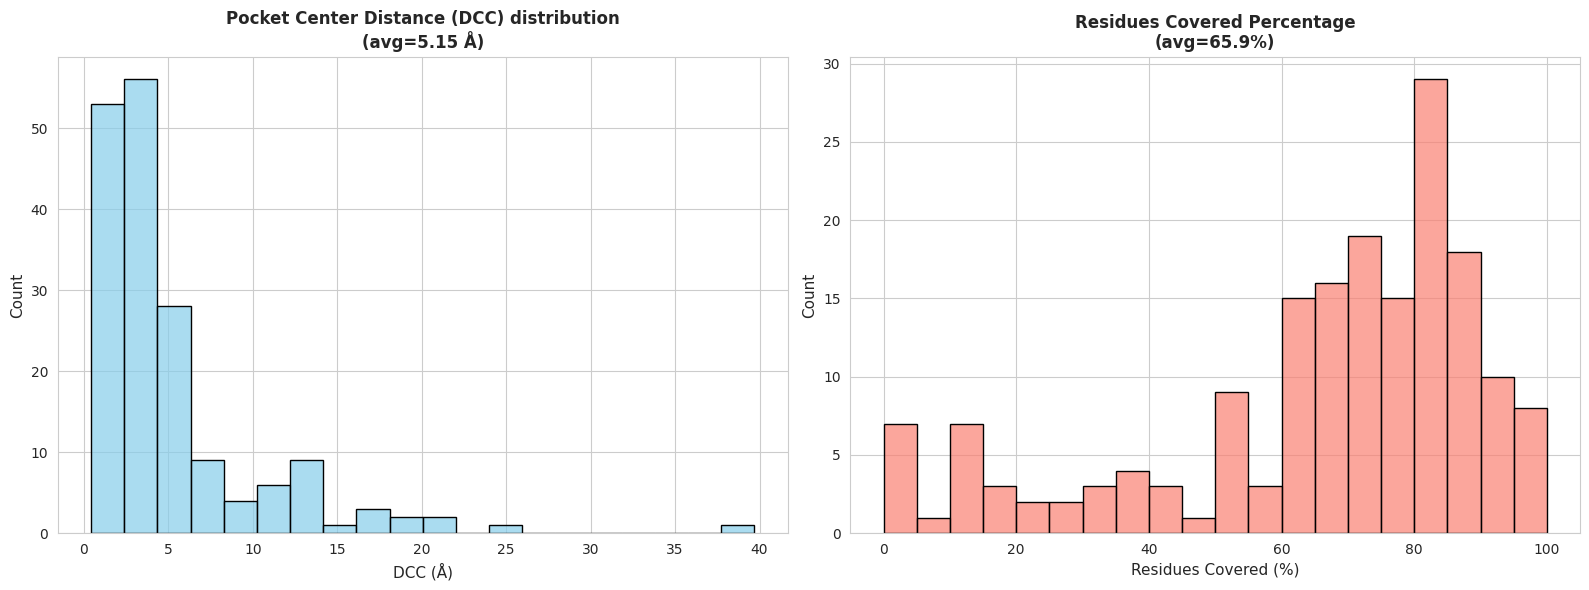

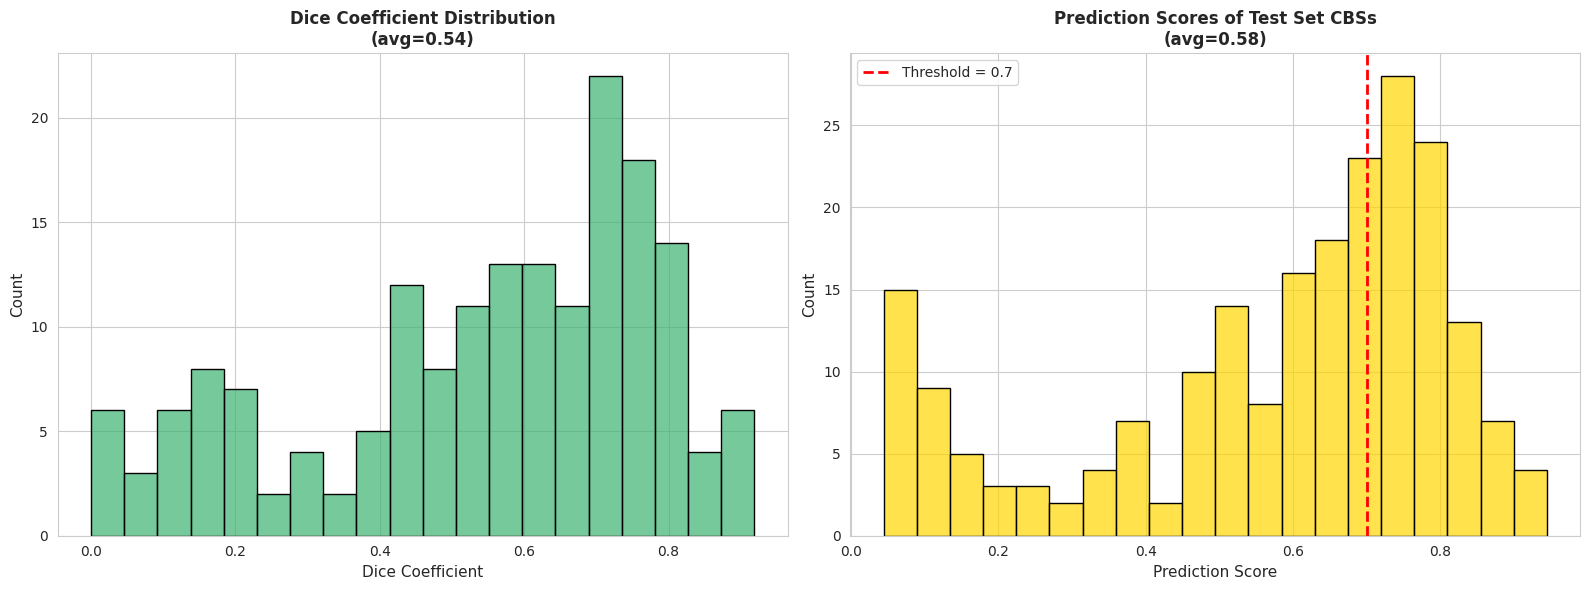

In [8]:
dcc_values = []
dice_coefficients = []
residues_covered_percent = []
prediction_scores_list = []

for structure, cryptic_pocket_list in cryptic_pockets.items():
    if structure not in refined_clusters:
        continue

    unrefined = refined_clusters[structure]
    ca_coords = structure_coords[structure]

    for cryptic_pocket in cryptic_pocket_list:
        total_residues_covered = 0
        cryptic_pocket_residues = set([residue.split("_")[1] for residue in cryptic_pocket])

        expected_indices = [int(i) for i in cryptic_pocket_residues]
        if expected_indices:
            mean_score = np.mean([prediction_scores[structure][i] for i in expected_indices])
            prediction_scores_list.append(mean_score)

        best_dist = float('inf')
        best_dice = 0
        best_covered = 0

        for potential_pocket in unrefined.values():
            # potential_pocket is a tuple: (residues, indices)
            indices_array = potential_pocket
            potential_pocket_str = set(str(r) for r in indices_array)
            residues_covered = len(potential_pocket_str & cryptic_pocket_residues)
            total_residues_covered += residues_covered

            actual_indices = indices_array

            if len(expected_indices) == 0 or len(actual_indices) == 0:
                continue

            dist = compute_center_distance(np.array(ca_coords), expected_indices, actual_indices)
            dice_coefficient = 2 * residues_covered / (len(cryptic_pocket_residues) + len(potential_pocket_str)) if (len(cryptic_pocket_residues) + len(potential_pocket_str)) > 0 else 0

            if dist < best_dist:
                best_dist = dist  
            if residues_covered > best_covered:
                best_covered = residues_covered
            if dice_coefficient > best_dice:
                best_dice = dice_coefficient

        percent_covered = best_covered / len(cryptic_pocket_residues) * 100 if cryptic_pocket_residues else 0
        # avoid the corner cases
        if np.isfinite(best_dist):
            dcc_values.append(best_dist)
        
            dice_coefficients.append(best_dice)
            residues_covered_percent.append(percent_covered)

sns.set_style("whitegrid")
plt.rcParams['figure.facecolor'] = 'white'
os.makedirs('fig', exist_ok=True)

fig, axs = plt.subplots(1, 2, figsize=(16, 6))

sns.histplot(dcc_values, bins=20, color='skyblue', edgecolor='black', alpha=0.7, ax=axs[0])
axs[0].set_title(f'Pocket Center Distance (DCC) distribution\n(avg={np.mean(dcc_values):.2f} Å)', fontsize=12, fontweight='bold')
axs[0].set_xlabel('DCC (Å)', fontsize=11)
axs[0].set_ylabel('Count', fontsize=11)

sns.histplot(residues_covered_percent, bins=20, color='salmon', edgecolor='black', alpha=0.7, ax=axs[1])
axs[1].set_title(f'Residues Covered Percentage\n(avg={np.mean(residues_covered_percent):.1f}%)', fontsize=12, fontweight='bold')
axs[1].set_xlabel('Residues Covered (%)', fontsize=11)
axs[1].set_ylabel('Count', fontsize=11)

plt.tight_layout()
plt.show()

fig, axs = plt.subplots(1, 2, figsize=(16, 6))

sns.histplot(dice_coefficients, bins=20, color='mediumseagreen', edgecolor='black', alpha=0.7, ax=axs[0])
axs[0].set_title(f'Dice Coefficient Distribution\n(avg={np.mean(dice_coefficients):.2f})', fontsize=12, fontweight='bold')
axs[0].set_xlabel('Dice Coefficient', fontsize=11)
axs[0].set_ylabel('Count', fontsize=11)

sns.histplot(prediction_scores_list, bins=20, color='gold', edgecolor='black', alpha=0.7, ax=axs[1])
axs[1].axvline(0.7, color='red', linestyle='--', linewidth=2, label='Threshold = 0.7')
axs[1].set_title(f'Prediction Scores of Test Set CBSs\n(avg={np.mean(prediction_scores_list):.2f})', fontsize=12, fontweight='bold')
axs[1].set_xlabel('Prediction Score', fontsize=11)
axs[1].set_ylabel('Count', fontsize=11)
axs[1].legend(fontsize=10)

plt.tight_layout()
plt.show()

# Try different DECISION thresholds
Use different decision threshold and observe how it affects the pocket-level metrics.


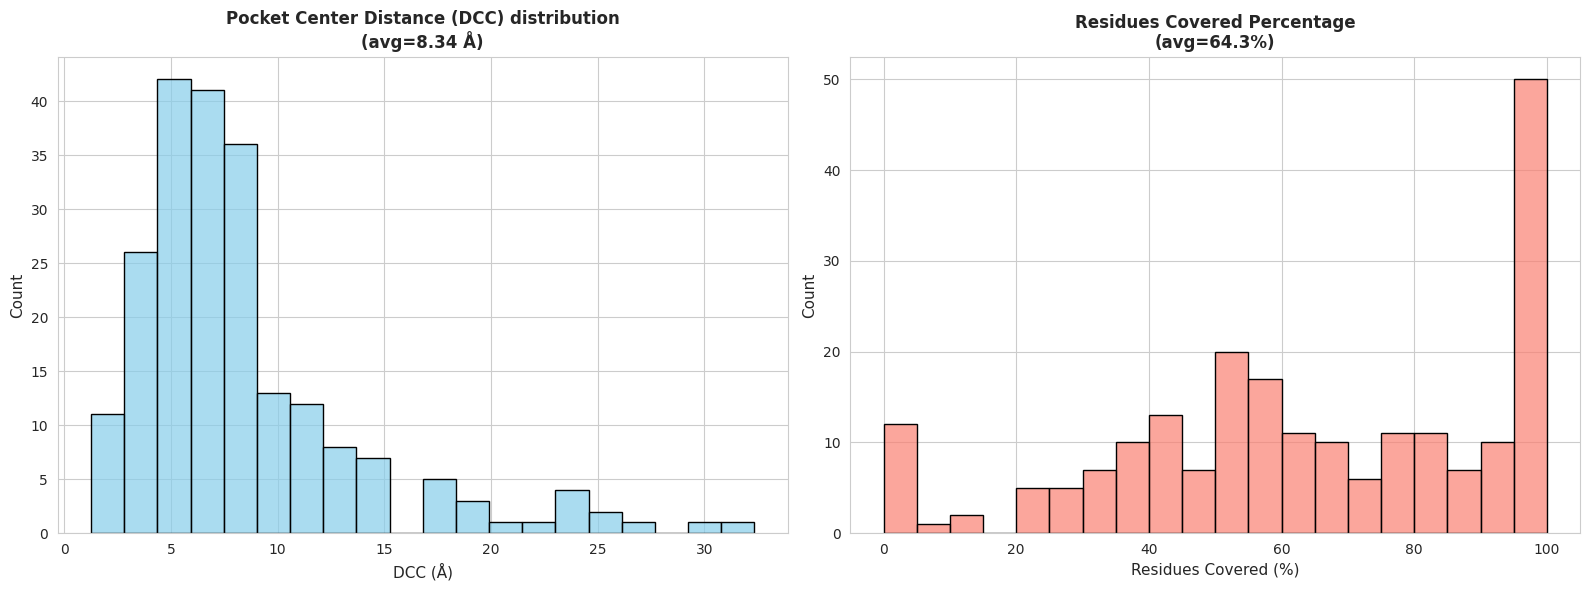

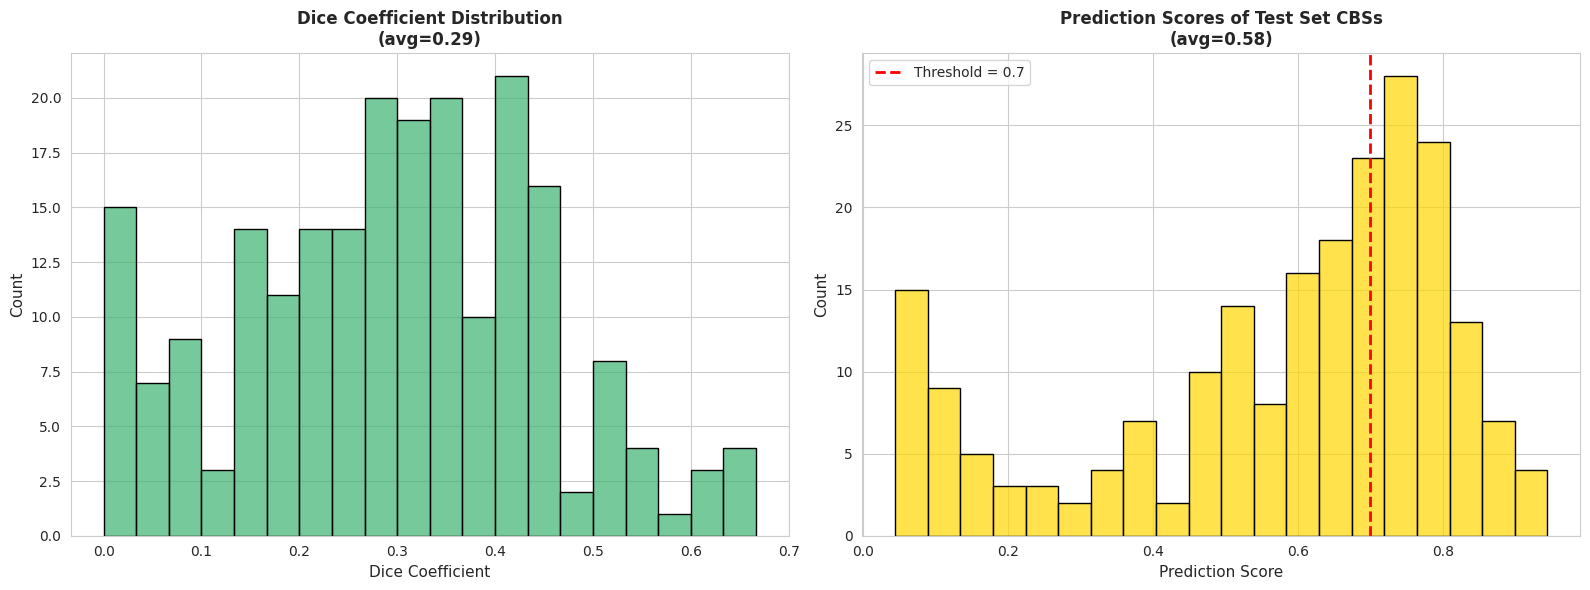

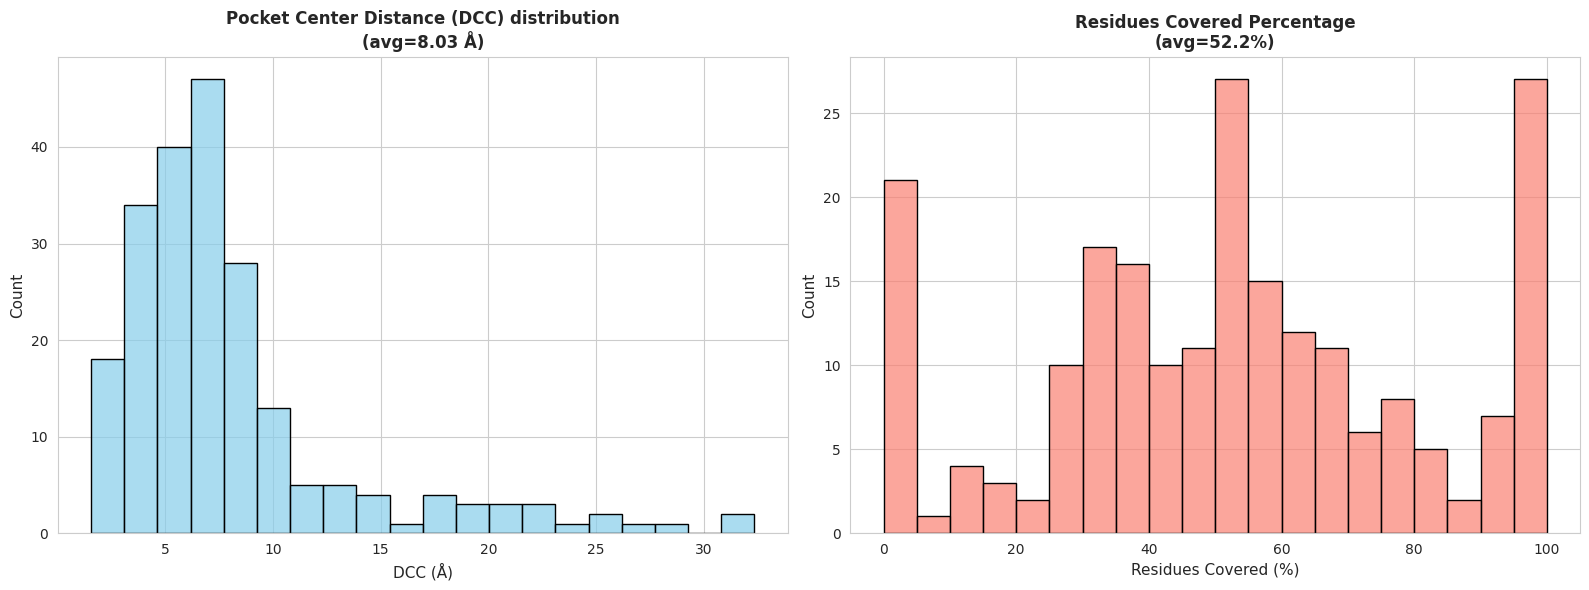

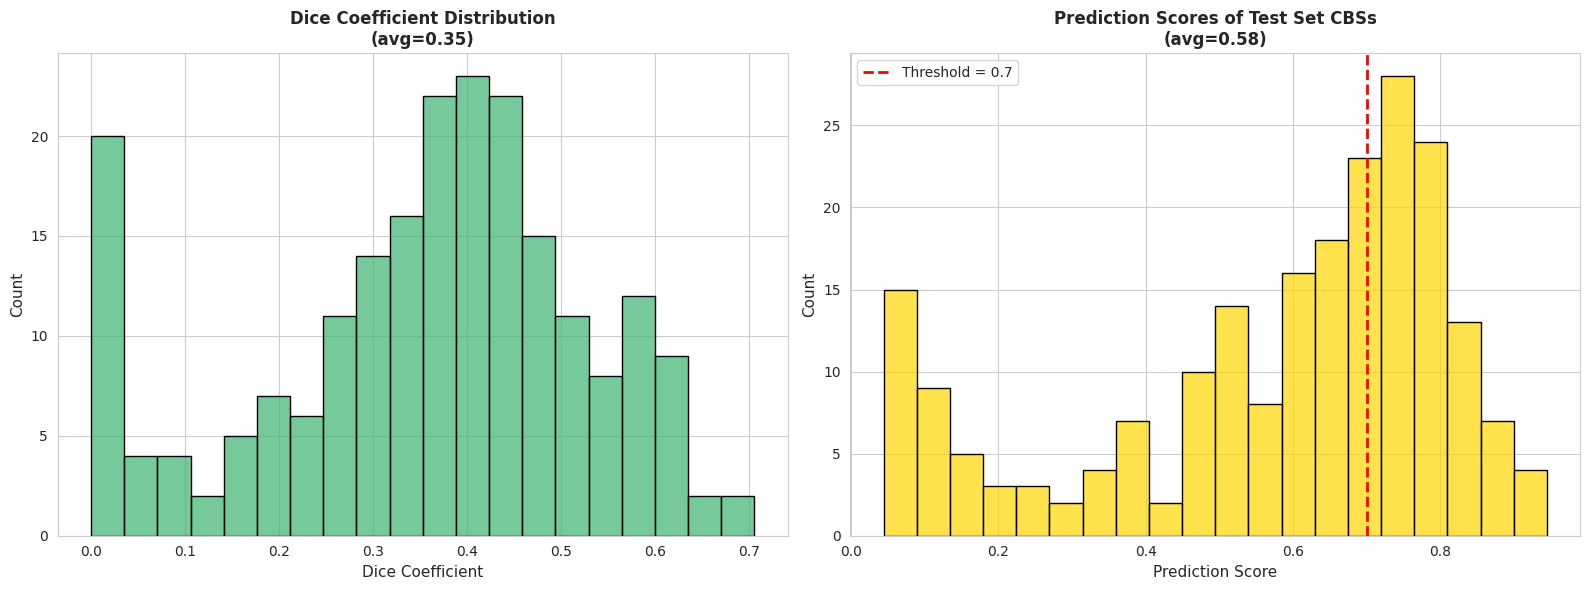

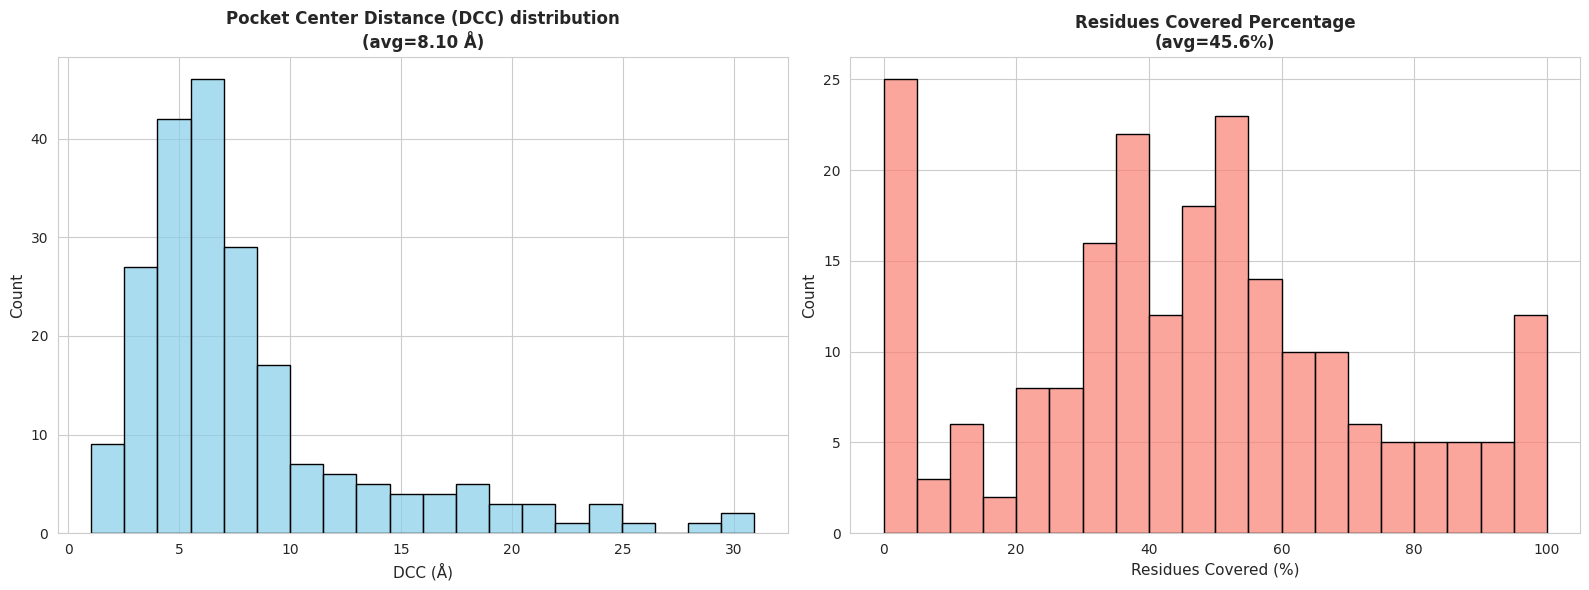

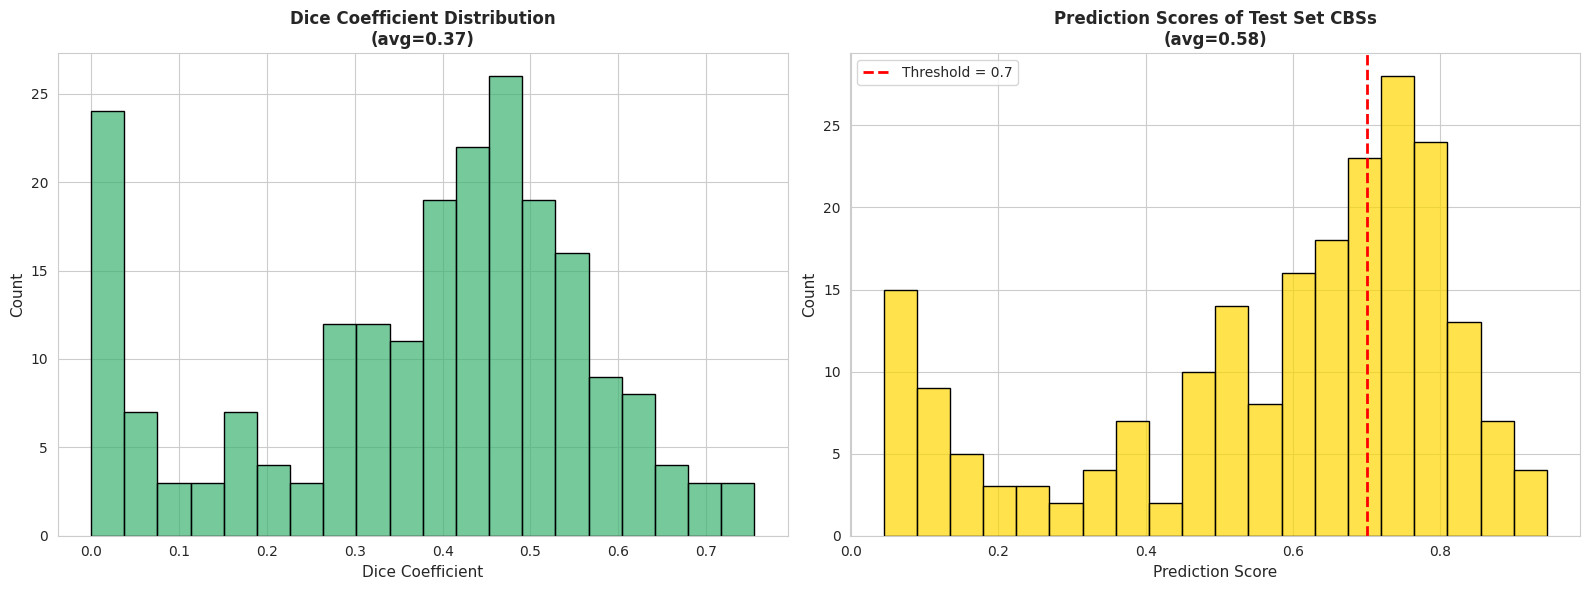

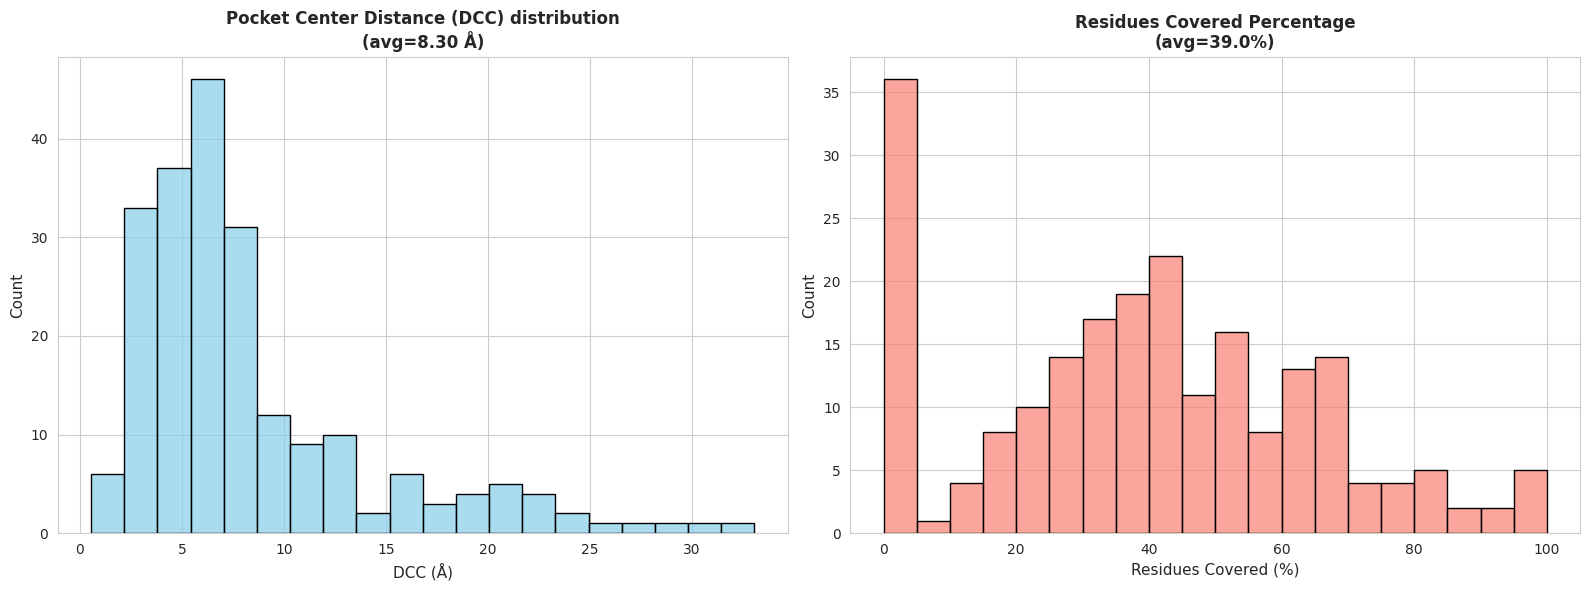

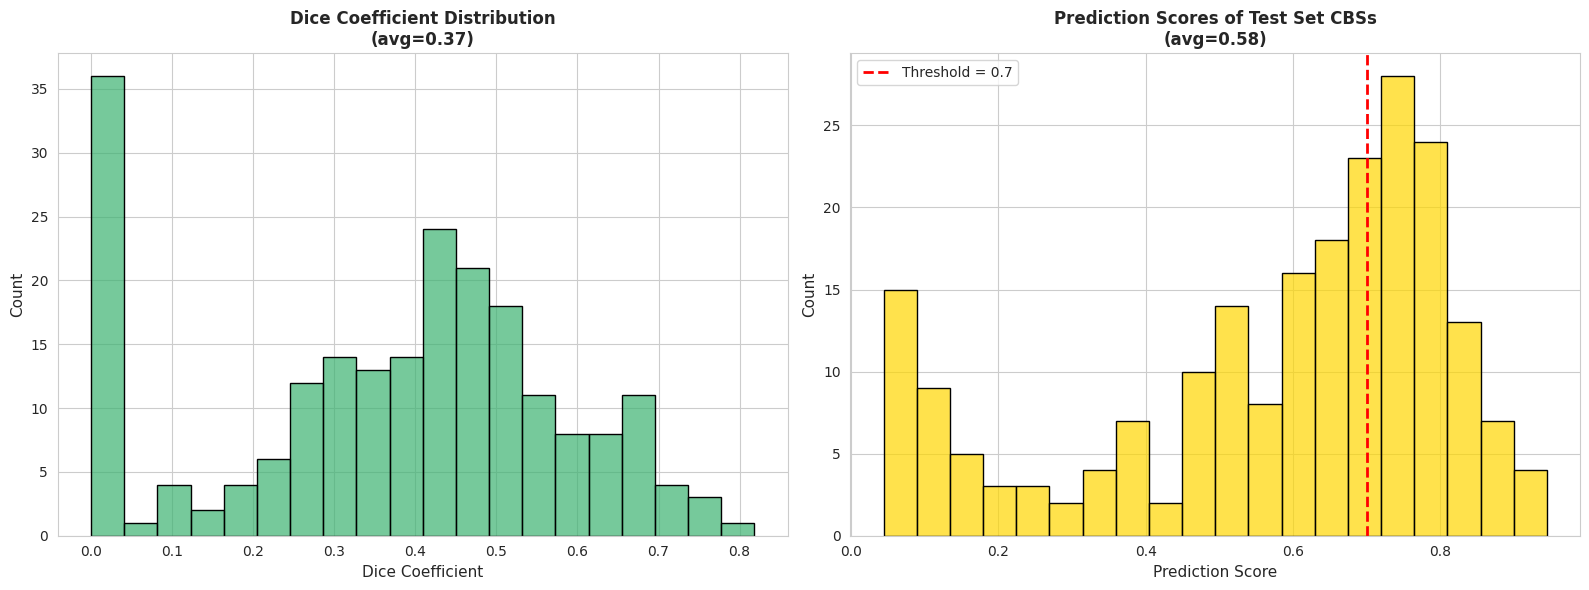

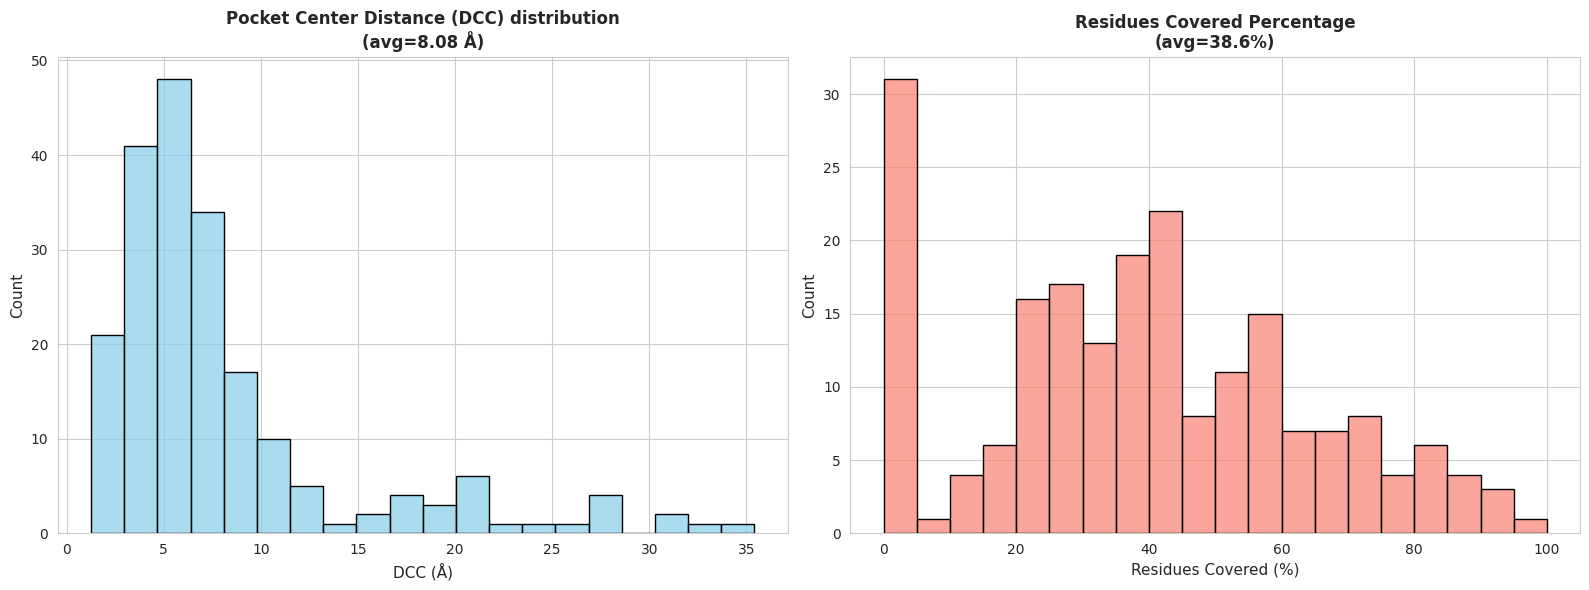

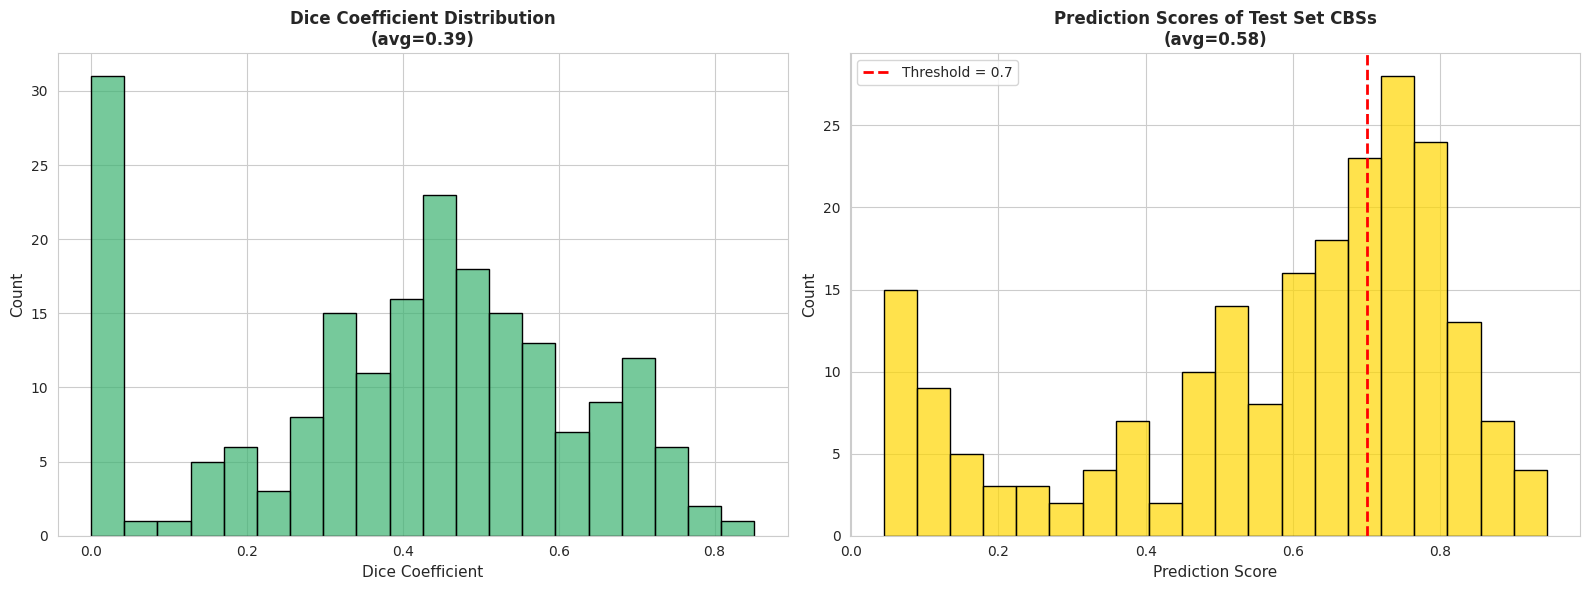

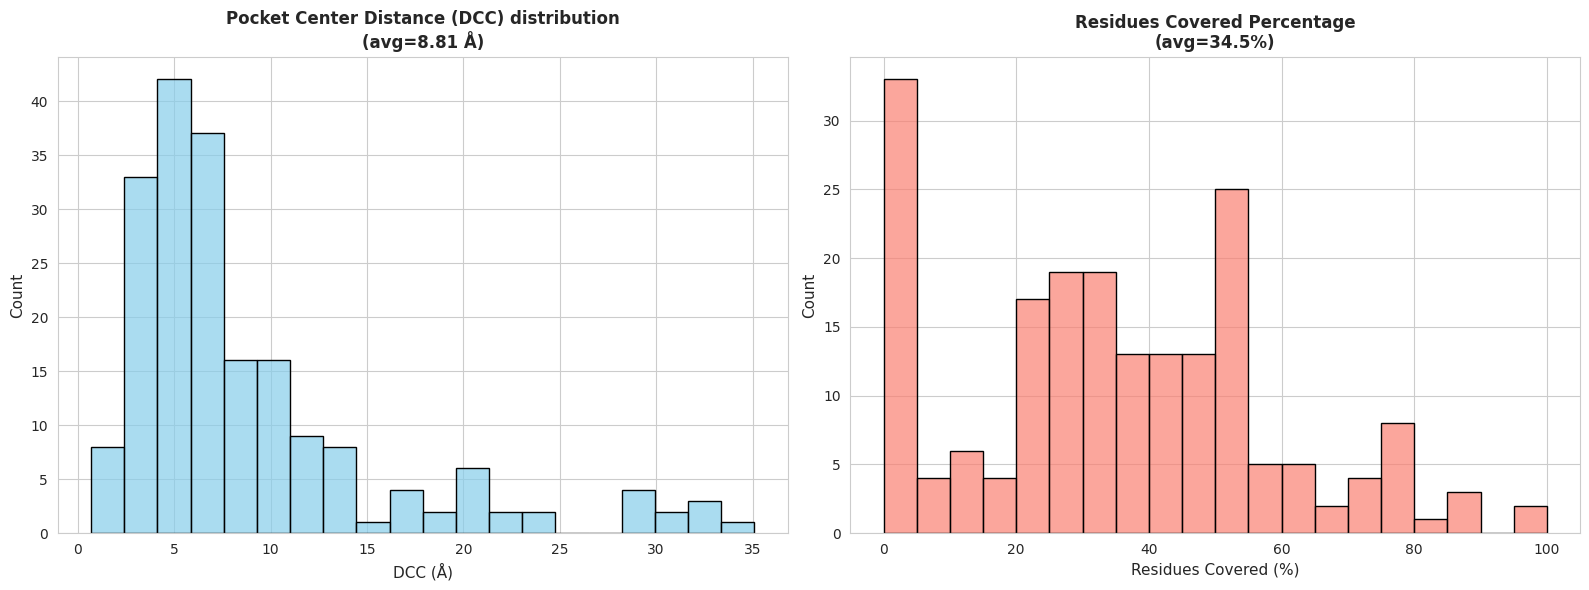

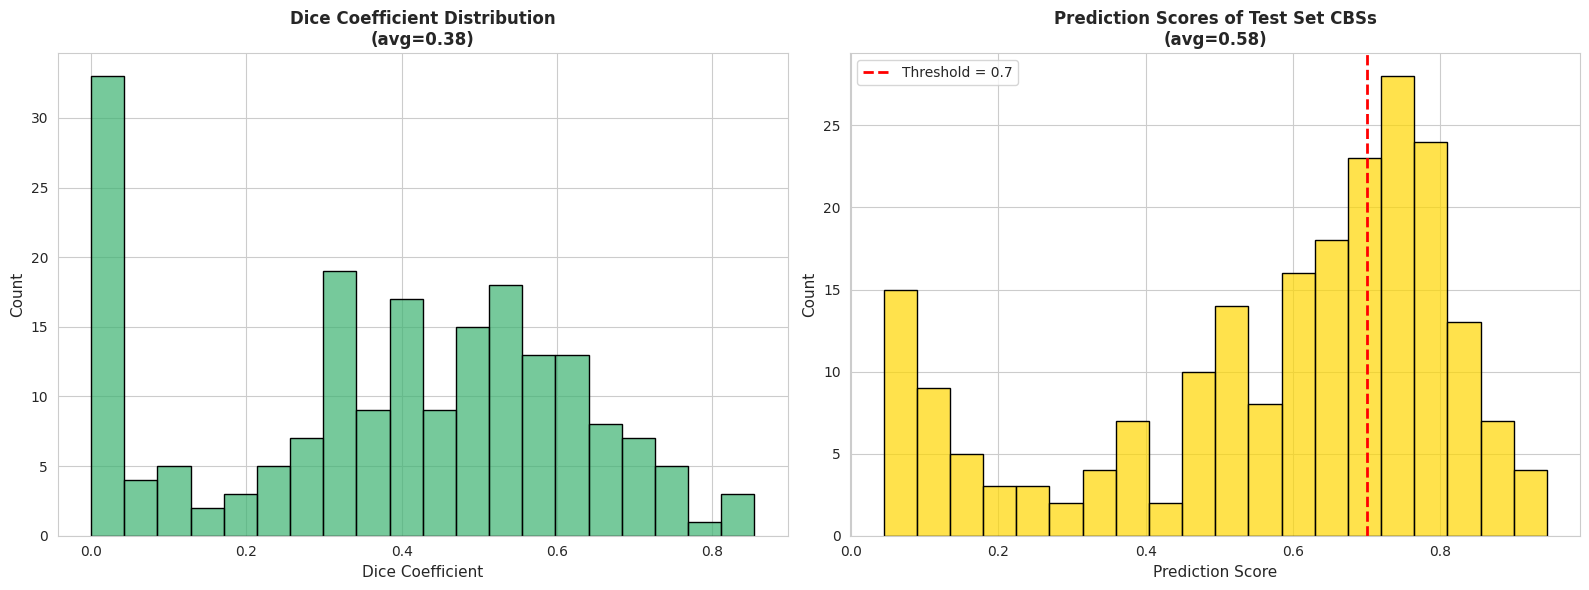

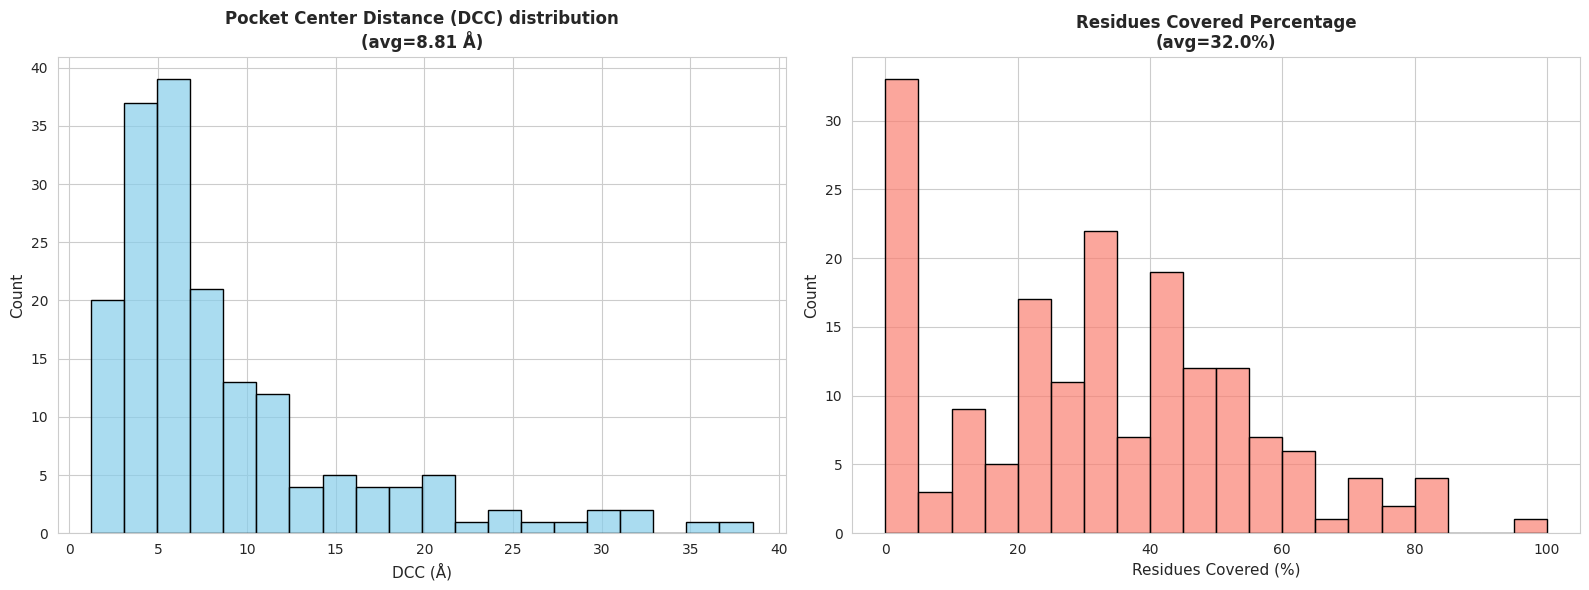

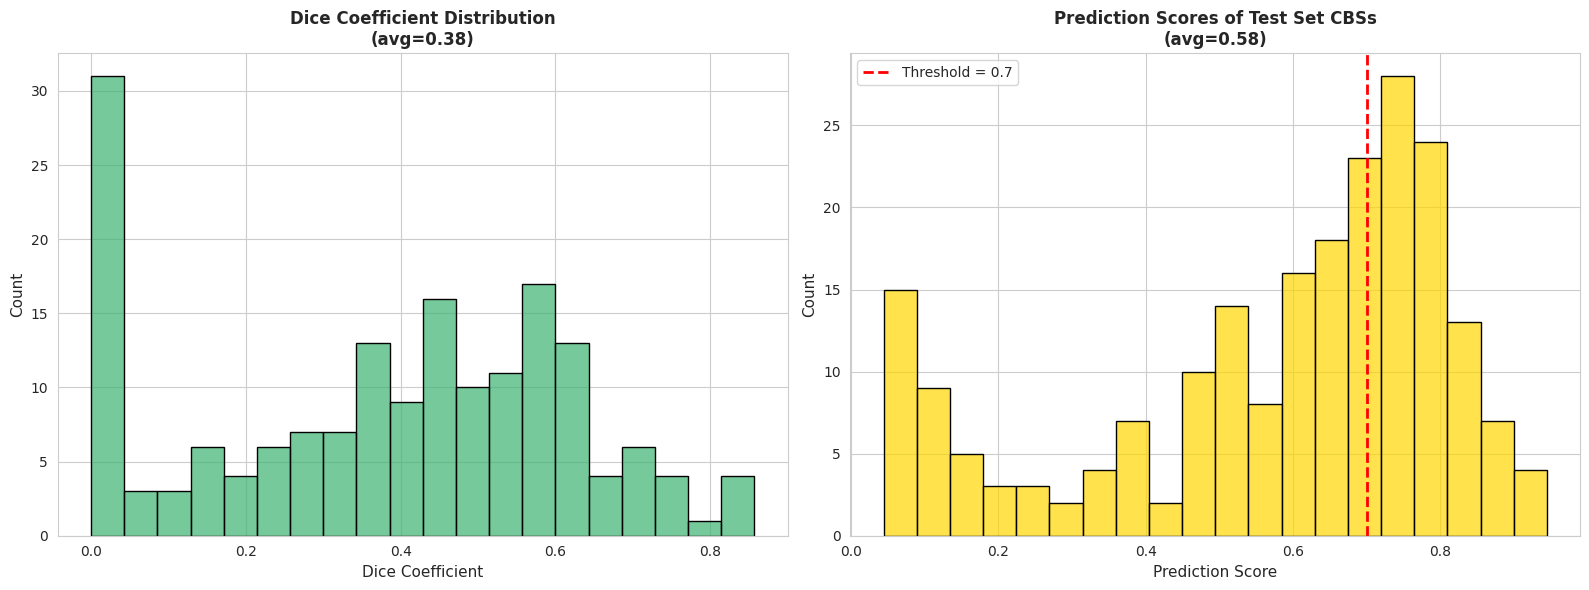

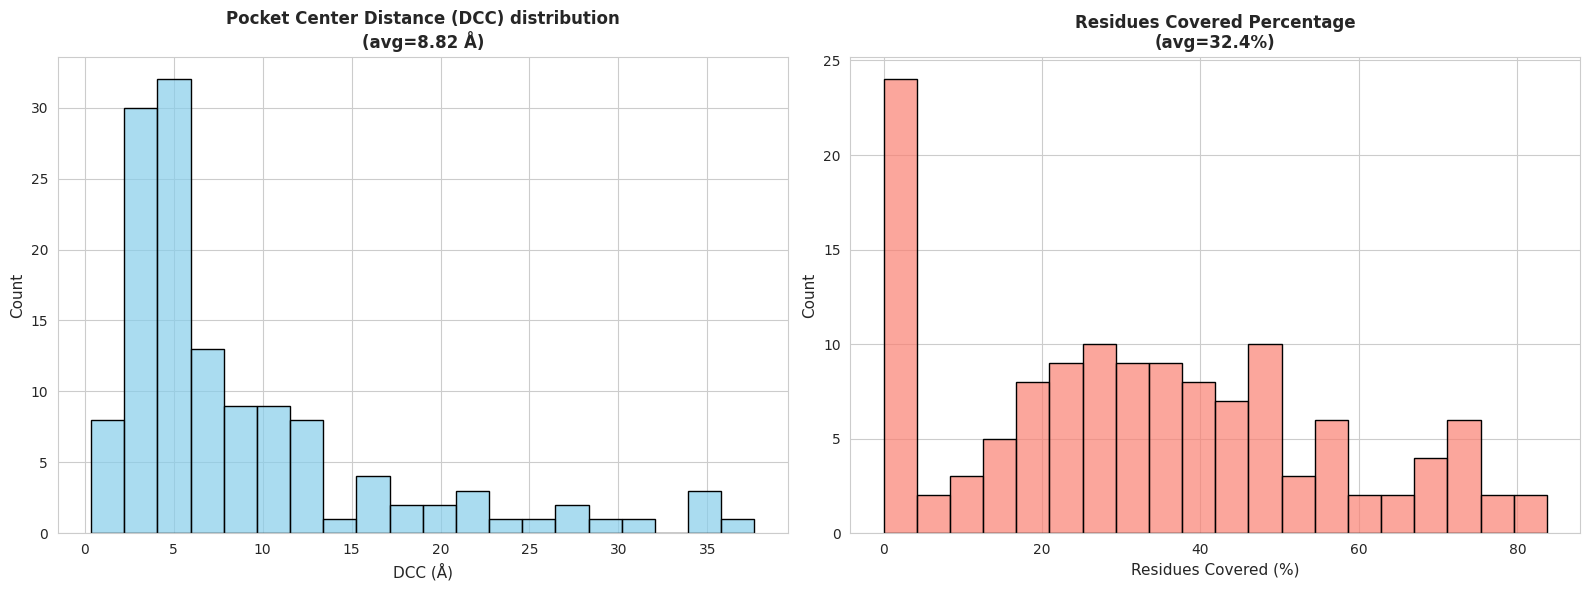

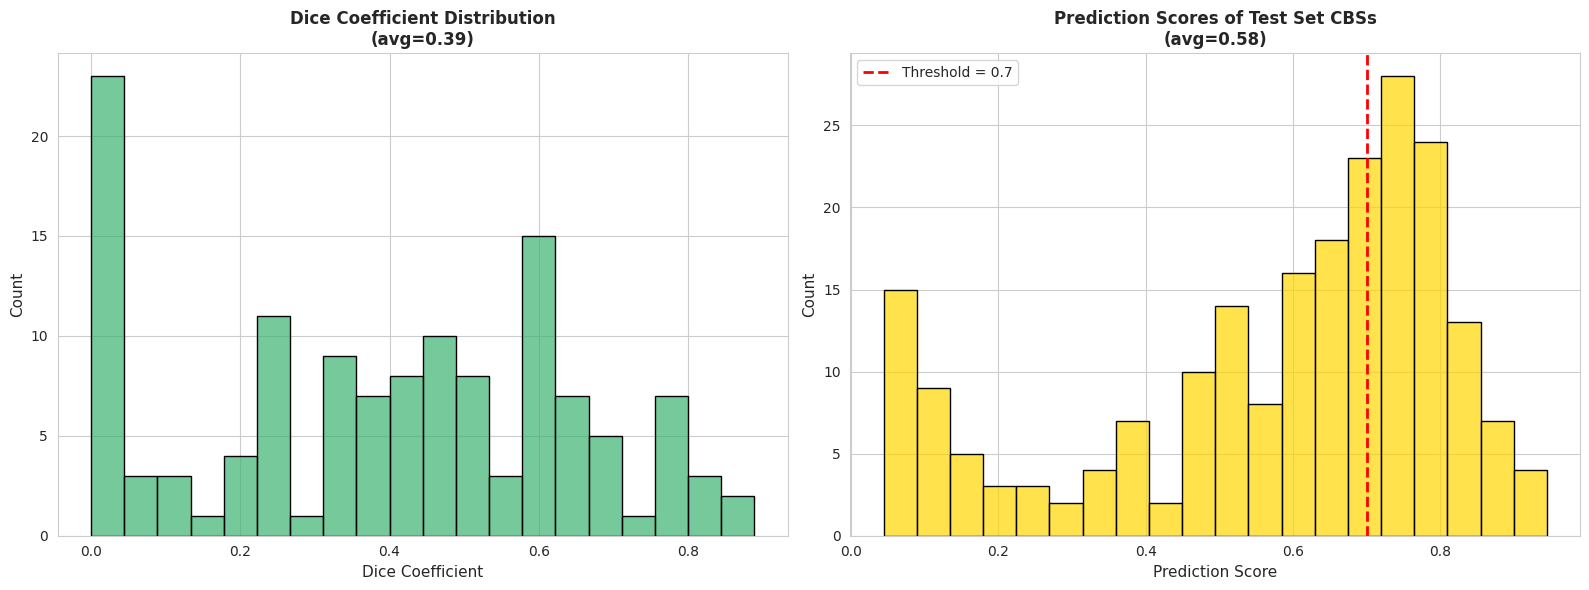

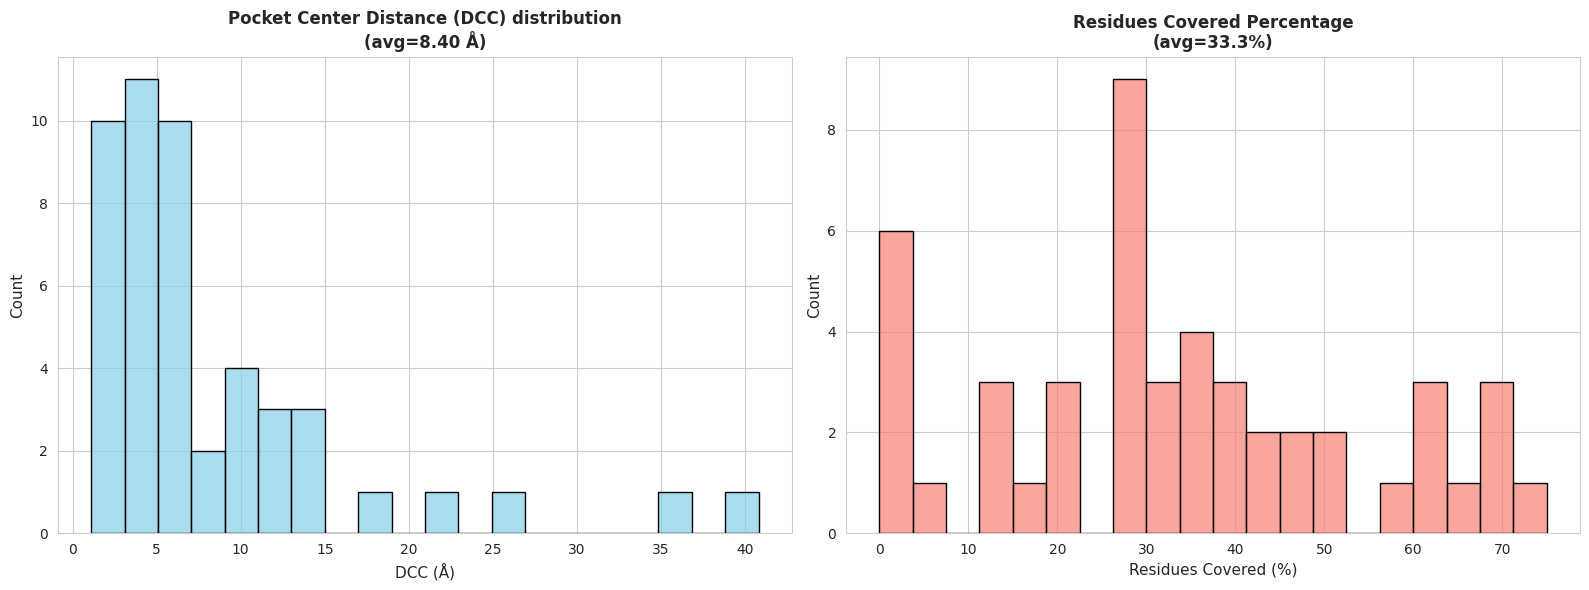

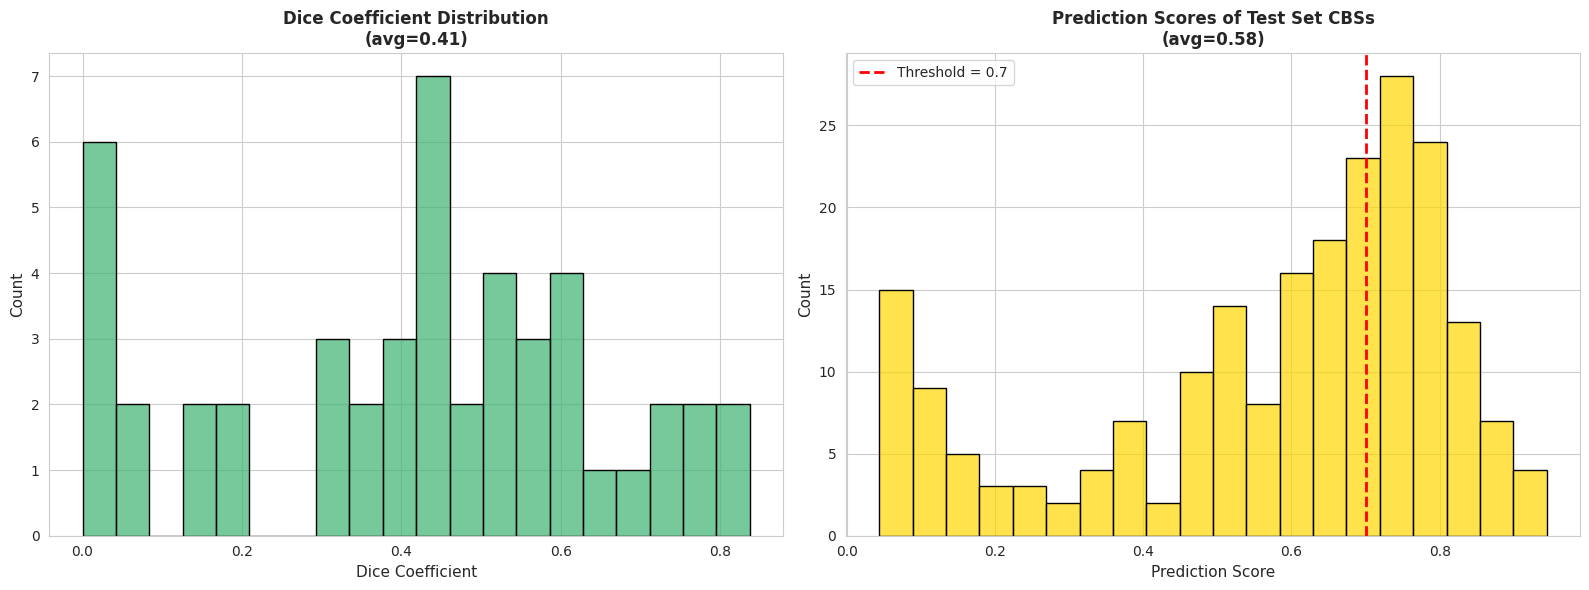

In [ ]:
os.makedirs("./tmp", exist_ok=True)
sys.path.append('/home/skrhakv/cryptic-nn/src')
import finetuning_utils

refined_clusters = {}
prediction_scores = {}
structure_coords = {}

SMOOTHING_MODEL_PATH = '/home/skrhakv/cryptoshow-analysis/data/C-optimize-smoother/smoother.pt'
smoothing_model = torch.load(SMOOTHING_MODEL_PATH, weights_only=False)
COORDINATES_DIR = '/home/skrhakv/cryptoshow-analysis/data/A-cluster-ligysis-data/coordinates'
DEBUG = False

def run_pocket_level_evaluation(high_score_threshold=0.7, smoothened_threshold=0.4):
    for structure in list(cryptic_pockets.keys()):
        structure_name, chain_id = structure.split("_")

        # get the structure sequence
        pdb_id = structure_name.lower()

        coordinates_path = f'{COORDINATES_DIR}/{structure.replace('_', '')}.npy'
        sequence = sequences[structure]
        ca_coords = np.load(coordinates_path)
        if DEBUG:
            print(f"Processing {structure_name} with chain {chain_id} and sequence length {len(sequence)}")

        assert len(ca_coords) == len(sequence), f"CA coordinates length {len(ca_coords)} does not match sequence length {len(sequence)}"

        prediction = compute_prediction(sequence, f"./tmp/{structure_name}_{chain_id}.npy")
        assert len(prediction) == len(sequence), f"Prediction length {len(prediction)} does not match sequence length {len(sequence)}"

        clusters = compute_clusters(ca_coords, prediction, high_score_threshold=high_score_threshold)

        # loop over each cluster in the predicted clusters
        for cluster_label in np.unique(clusters):
            if cluster_label == -1:
                continue
            
            # SEEMS LIKE HERE IS THE SAME MISTAKE AS I DID BEFORE: binding residues are loaded from the CB test set,
            # and not from the predicted clusters. This means that the information is leaked from the test set into the smoothing.

            # cryptic_pocket_flat = [] # final format: [240, 241, 243, 244, 266, 267, 268, 271, 272, 273]
            cryptic_pocket_flat = np.where(clusters == cluster_label)[0].tolist()


            binding_residues = [] # final format: ['T240', 'D241', 'A243', 'A244', 'L266', 'T267', 'Q268', 'R271', 'T272', 'S273']
            for residue_num in cryptic_pocket_flat:
                seq_index = residue_num
                aa = sequence[seq_index]
                binding_residues.append(f"{aa}{seq_index}")

            if not binding_residues:
                if DEBUG:
                    print(f"No valid binding residues found for {structure}. Skipping...")
                continue

            single_for_prediction = process_single_sequence(
                structure_name=structure_name,
                chain_id=chain_id,
                binding_residues=binding_residues,
                sequence=sequence,
                embedding_path=f"./tmp/{structure_name}_{chain_id}.npy",
                distance_matrix=compute_distance_matrix(ca_coords)
            )

            if single_for_prediction[0].shape[0] == 0:
                if DEBUG:
                    print(f"Empty arrays returned from process_single_sequence. Skipping smoothing...")
                continue

            smoothened_prediction = predict_single_sequence(*single_for_prediction, model_3=smoothing_model)

            # this is defined by the training data - best F1 score was achieved with this threshold 
            # DECISION_THRESHOLD = 0.4 # see src/C-optimize-smoother/classifier-for-cryptoshow.ipynb
            SMOOTHENED_THRESHOLD = smoothened_threshold

            selected_indices = np.where(smoothened_prediction['predictions'] > SMOOTHENED_THRESHOLD)[0]
            selected_indices_mapped = smoothened_prediction['indices'][selected_indices]

            for idx in selected_indices_mapped:
                clusters[idx] = cluster_label
        # get each of the clusters that is not -1 and save them
        refined_clusters[structure] = {}
        for cluster_id in np.unique(clusters):
            if cluster_id == -1:
                continue
            indices = np.where(clusters == cluster_id)[0]
            refined_clusters[structure][cluster_id] = indices

        prediction_scores[structure] = prediction
        structure_coords[structure] = ca_coords

    dcc_values = []
    dice_coefficients = []
    residues_covered_percent = []
    prediction_scores_list = []

    for structure, cryptic_pocket_list in cryptic_pockets.items():
        if structure not in refined_clusters:
            continue

        unrefined = refined_clusters[structure]
        ca_coords = structure_coords[structure]

        for cryptic_pocket in cryptic_pocket_list:
            total_residues_covered = 0
            cryptic_pocket_residues = set([residue.split("_")[1] for residue in cryptic_pocket])

            expected_indices = [int(i) for i in cryptic_pocket_residues]
            if expected_indices:
                mean_score = np.mean([prediction_scores[structure][i] for i in expected_indices])
                prediction_scores_list.append(mean_score)

            best_dist = float('inf')
            best_dice = 0
            best_covered = 0

            for potential_pocket in unrefined.values():
                # potential_pocket is a tuple: (residues, indices)
                indices_array = potential_pocket
                potential_pocket_str = set(str(r) for r in indices_array)
                residues_covered = len(potential_pocket_str & cryptic_pocket_residues)
                total_residues_covered += residues_covered

                actual_indices = indices_array

                if len(expected_indices) == 0 or len(actual_indices) == 0:
                    continue

                dist = compute_center_distance(np.array(ca_coords), expected_indices, actual_indices)
                dice_coefficient = 2 * residues_covered / (len(cryptic_pocket_residues) + len(potential_pocket_str)) if (len(cryptic_pocket_residues) + len(potential_pocket_str)) > 0 else 0

                if dist < best_dist:
                    best_dist = dist  
                if residues_covered > best_covered:
                    best_covered = residues_covered
                if dice_coefficient > best_dice:
                    best_dice = dice_coefficient

            percent_covered = best_covered / len(cryptic_pocket_residues) * 100 if cryptic_pocket_residues else 0
            # avoid the corner cases
            if np.isfinite(best_dist):
                dcc_values.append(best_dist)

                dice_coefficients.append(best_dice)
                residues_covered_percent.append(percent_covered)

    sns.set_style("whitegrid")
    plt.rcParams['figure.facecolor'] = 'white'
    os.makedirs('fig', exist_ok=True)

    fig, axs = plt.subplots(1, 2, figsize=(16, 6))

    sns.histplot(dcc_values, bins=20, color='skyblue', edgecolor='black', alpha=0.7, ax=axs[0])
    axs[0].set_title(f'Pocket Center Distance (DCC) distribution\n(avg={np.mean(dcc_values):.2f} Å)', fontsize=12, fontweight='bold')
    axs[0].set_xlabel('DCC (Å)', fontsize=11)
    axs[0].set_ylabel('Count', fontsize=11)
    axs[0].set_xlim(0, 50)

    sns.histplot(residues_covered_percent, bins=20, color='salmon', edgecolor='black', alpha=0.7, ax=axs[1])
    axs[1].set_title(f'Residues Covered Percentage\n(avg={np.mean(residues_covered_percent):.1f}%)', fontsize=12, fontweight='bold')
    axs[1].set_xlabel('Residues Covered (%)', fontsize=11)
    axs[1].set_ylabel('Count', fontsize=11)

    plt.tight_layout()
    plt.show()

    fig, axs = plt.subplots(1, 2, figsize=(16, 6))

    sns.histplot(dice_coefficients, bins=20, color='mediumseagreen', edgecolor='black', alpha=0.7, ax=axs[0])
    axs[0].set_title(f'Dice Coefficient Distribution\n(avg={np.mean(dice_coefficients):.2f})', fontsize=12, fontweight='bold')
    axs[0].set_xlabel('Dice Coefficient', fontsize=11)
    axs[0].set_ylabel('Count', fontsize=11)

    sns.histplot(prediction_scores_list, bins=20, color='gold', edgecolor='black', alpha=0.7, ax=axs[1])
    axs[1].axvline(0.7, color='red', linestyle='--', linewidth=2, label='Threshold = 0.7')
    axs[1].set_title(f'Prediction Scores of Test Set CBSs\n(avg={np.mean(prediction_scores_list):.2f})', fontsize=12, fontweight='bold')
    axs[1].set_xlabel('Prediction Score', fontsize=11)
    axs[1].set_ylabel('Count', fontsize=11)
    axs[1].legend(fontsize=10)

    plt.tight_layout()
    plt.show()

    
for high_source_threshold in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
    run_pocket_level_evaluation(high_score_threshold=high_source_threshold)

# Try different thresholds for smoothing


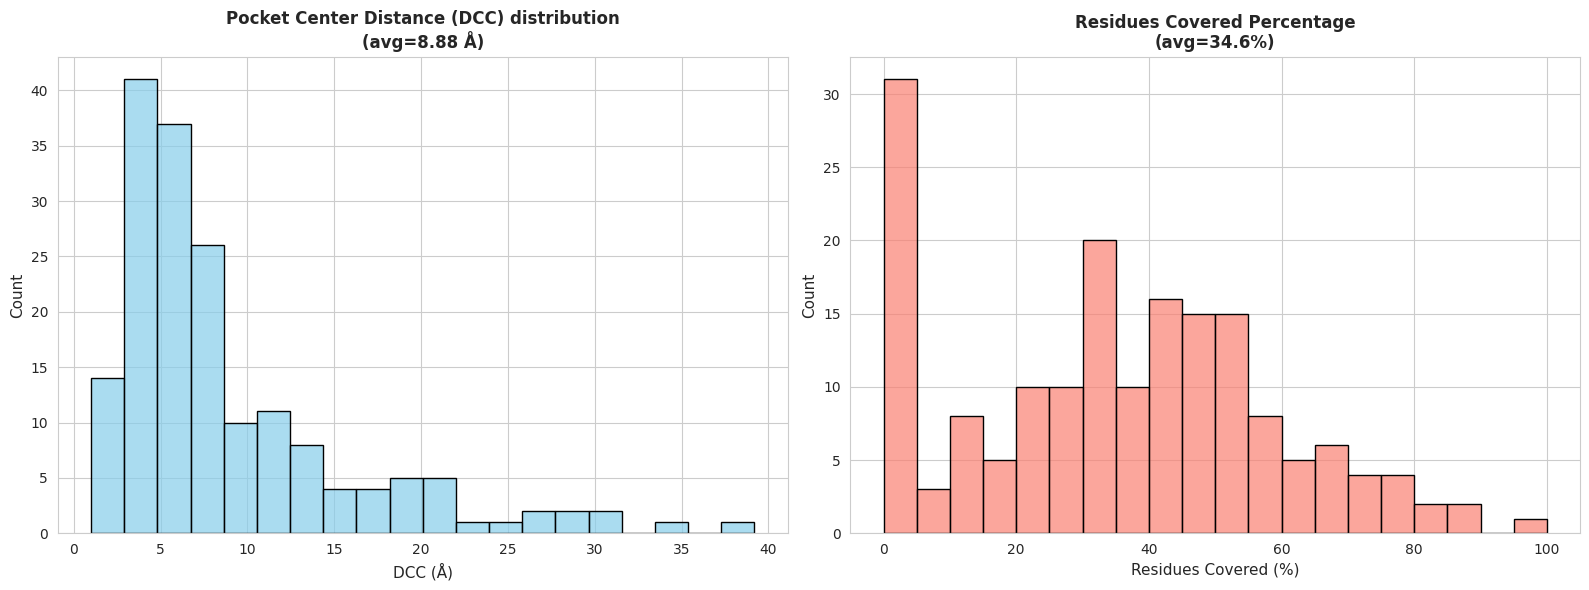

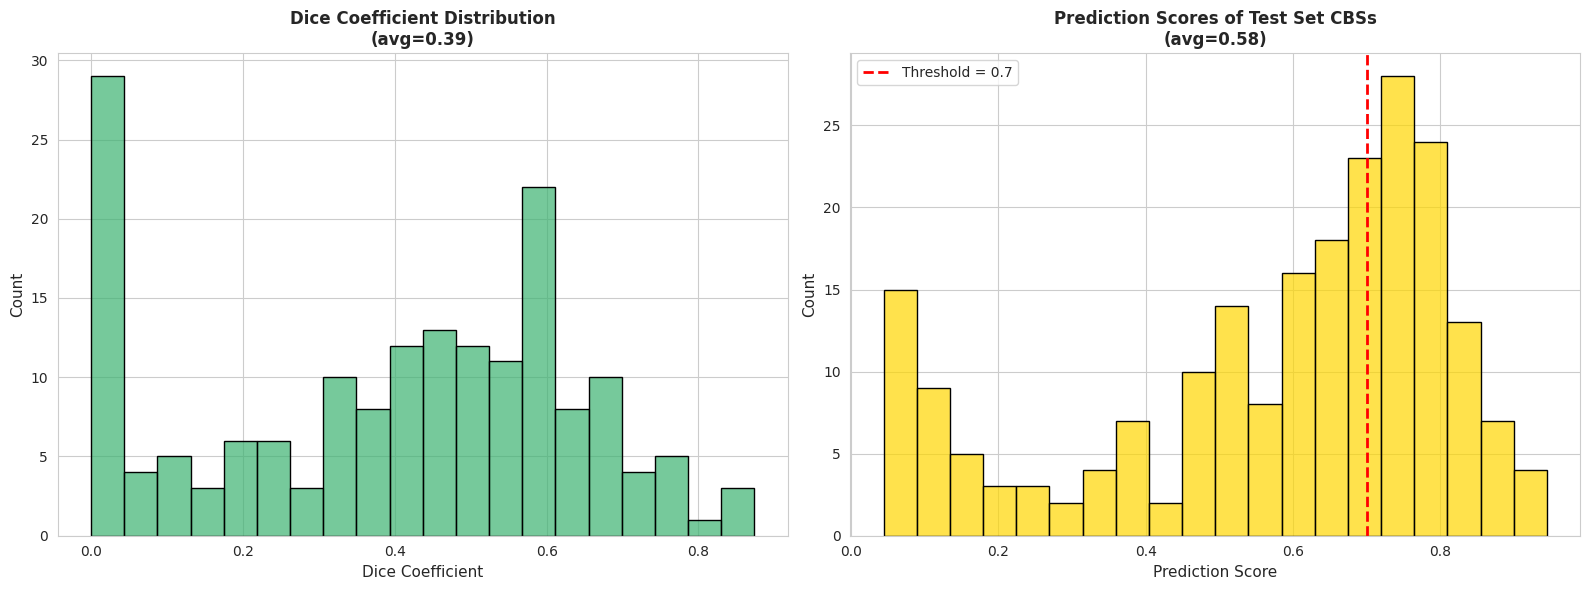

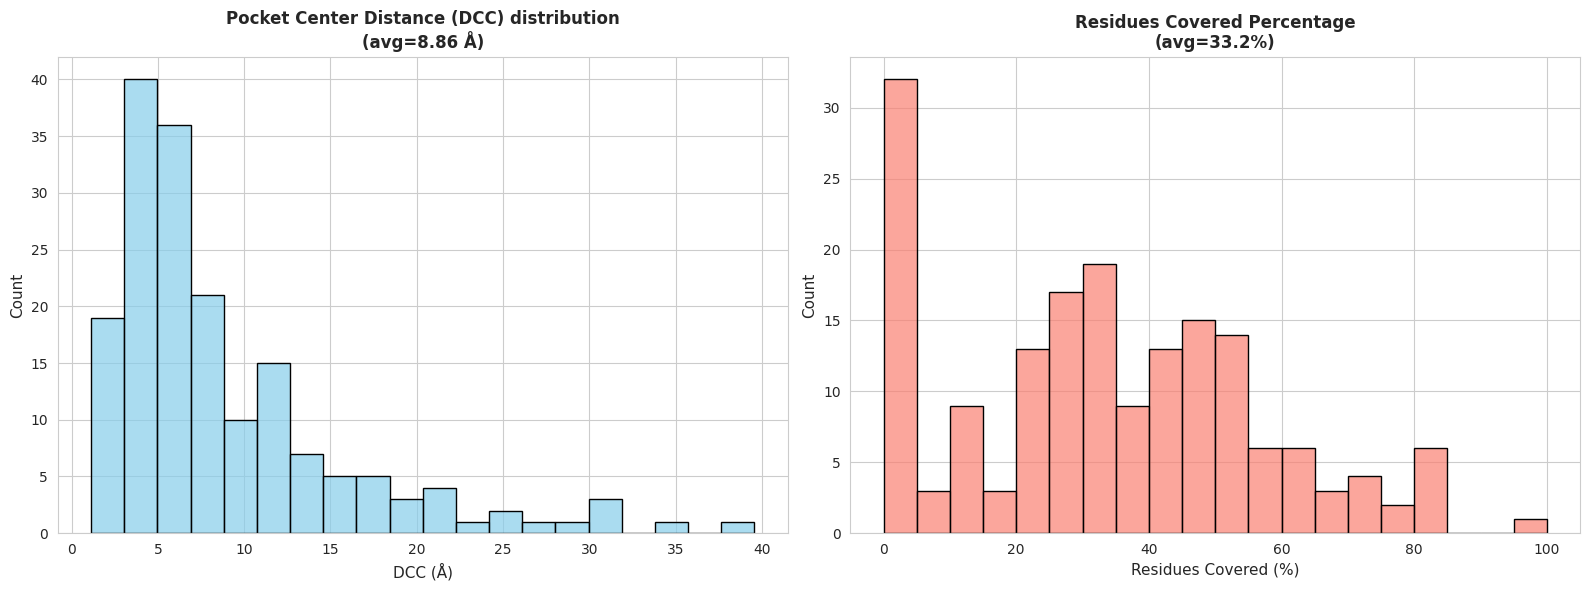

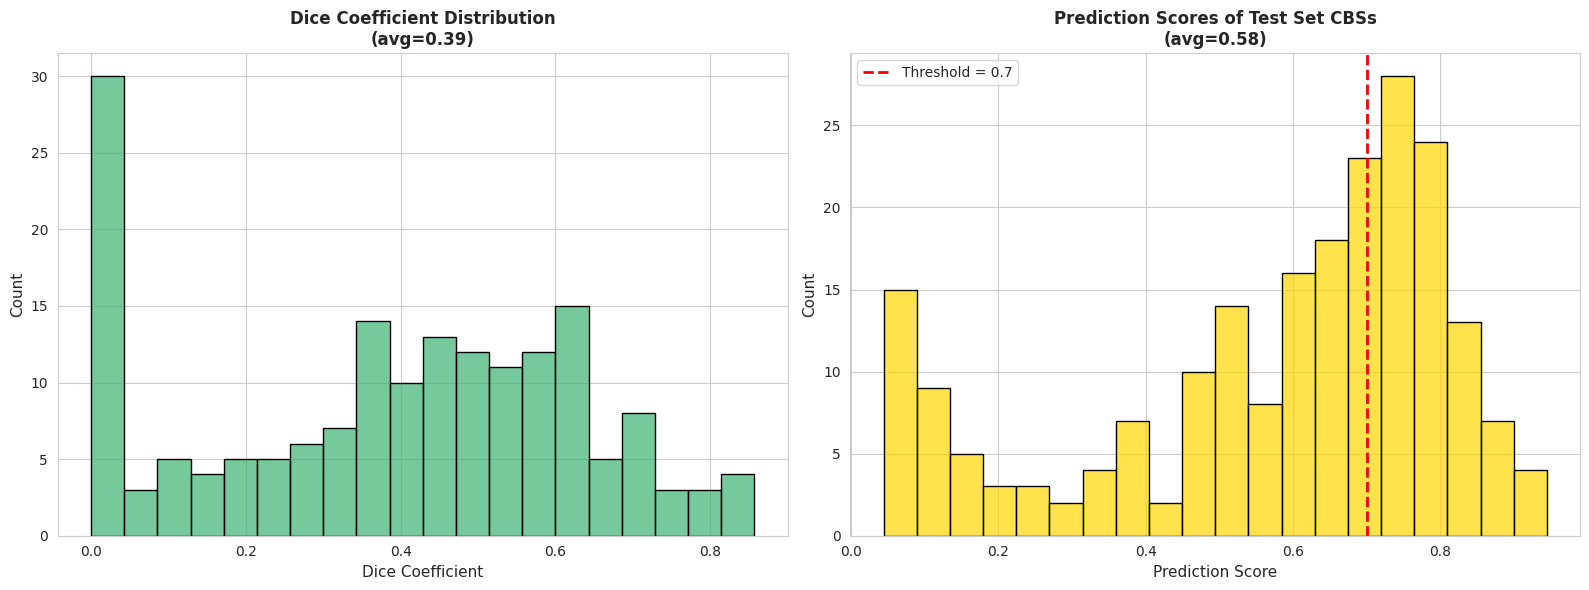

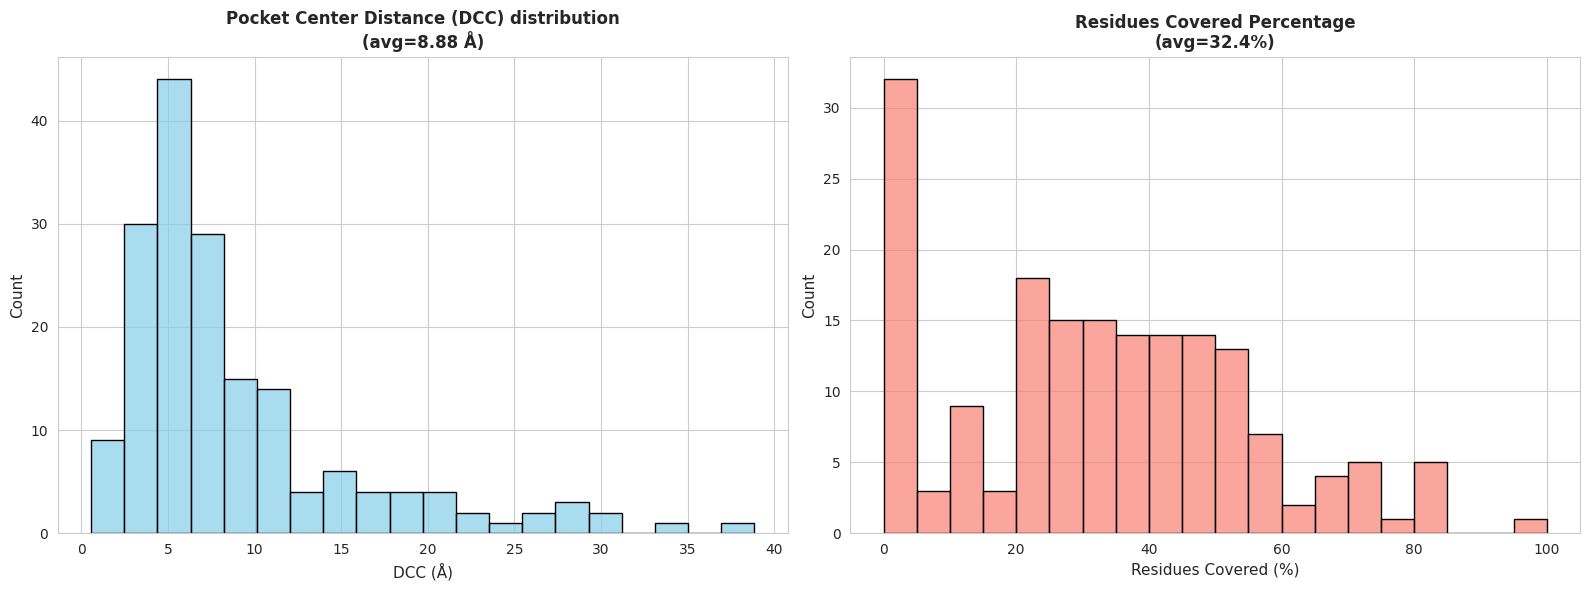

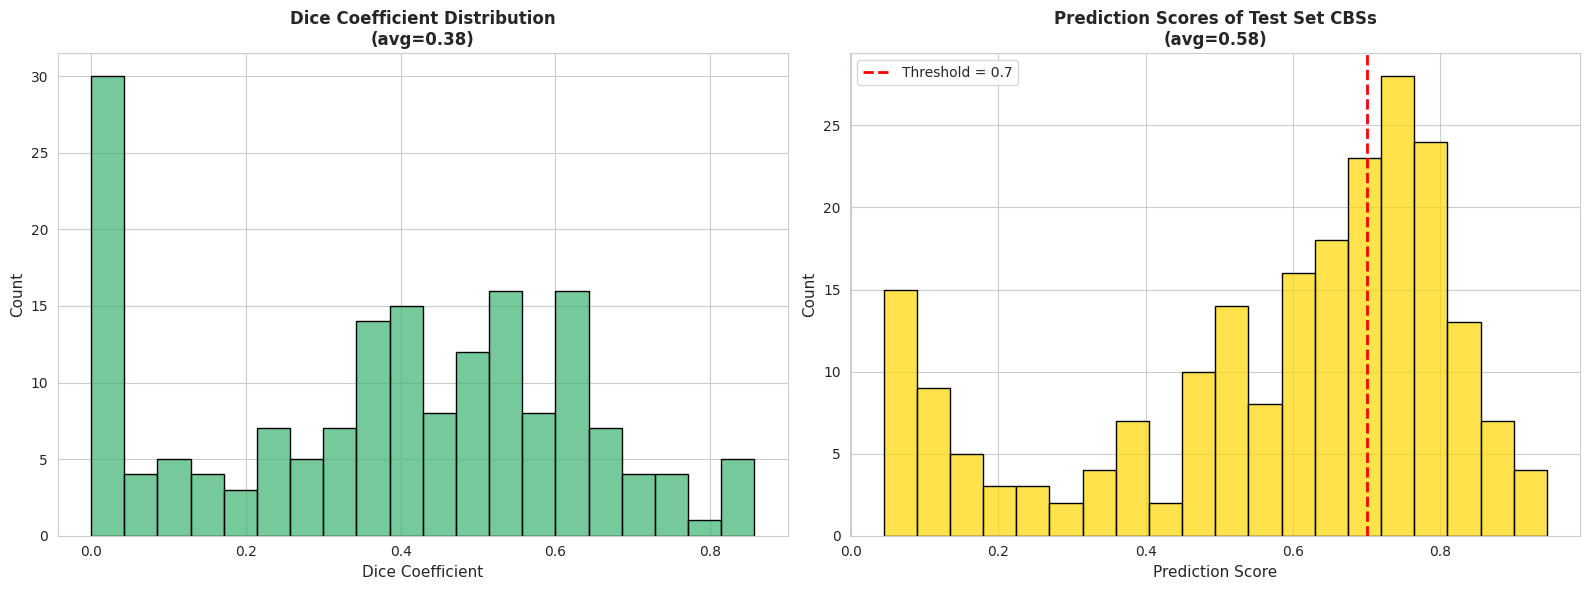

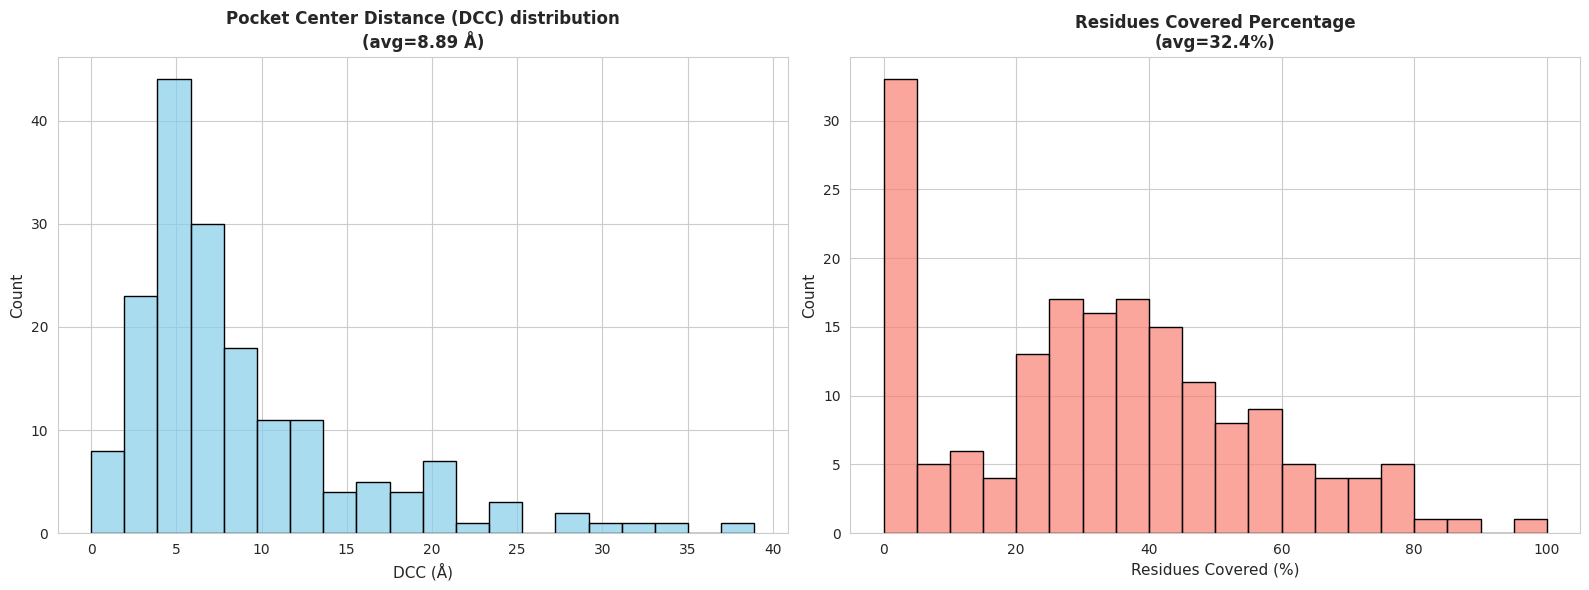

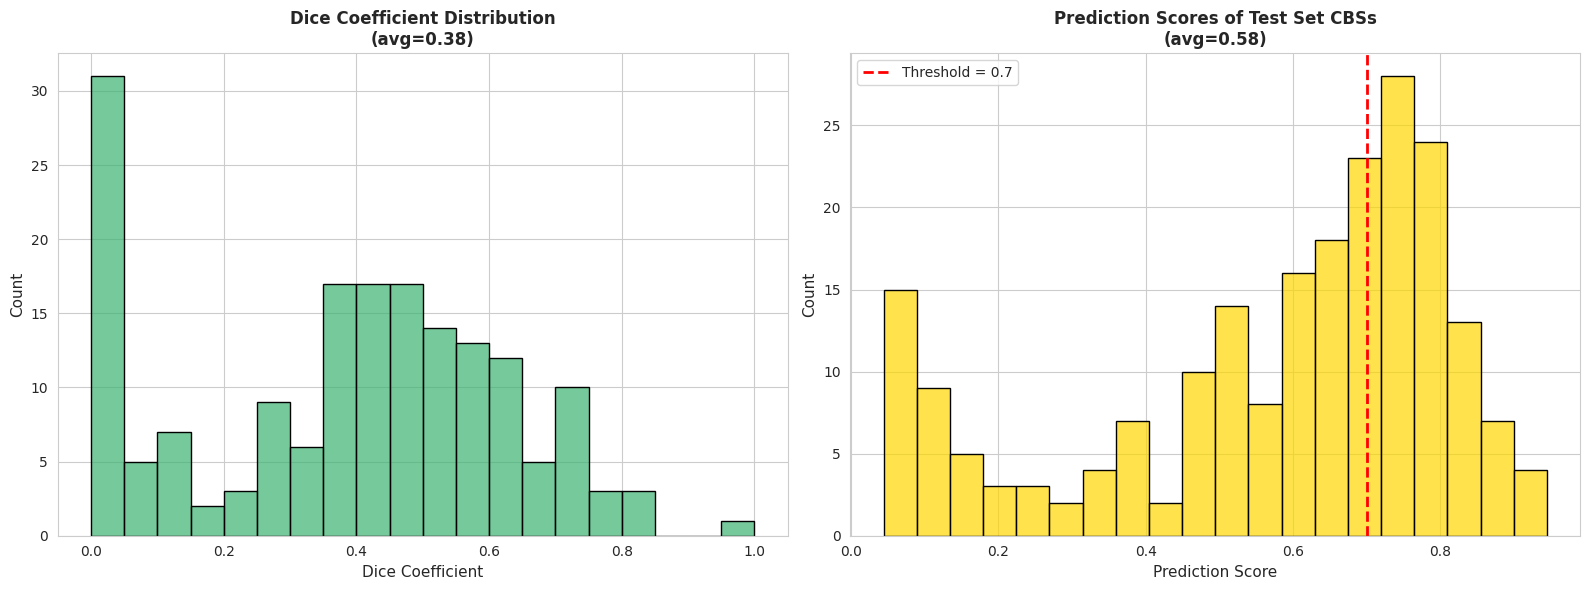

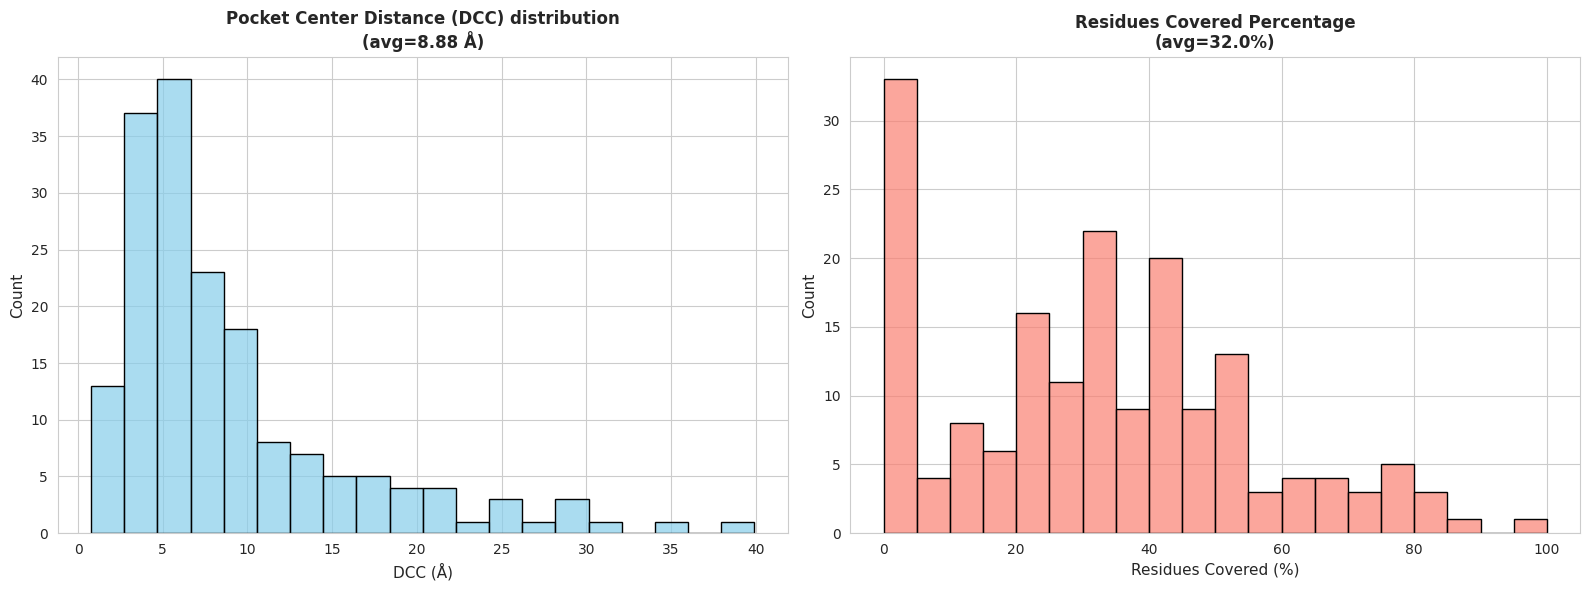

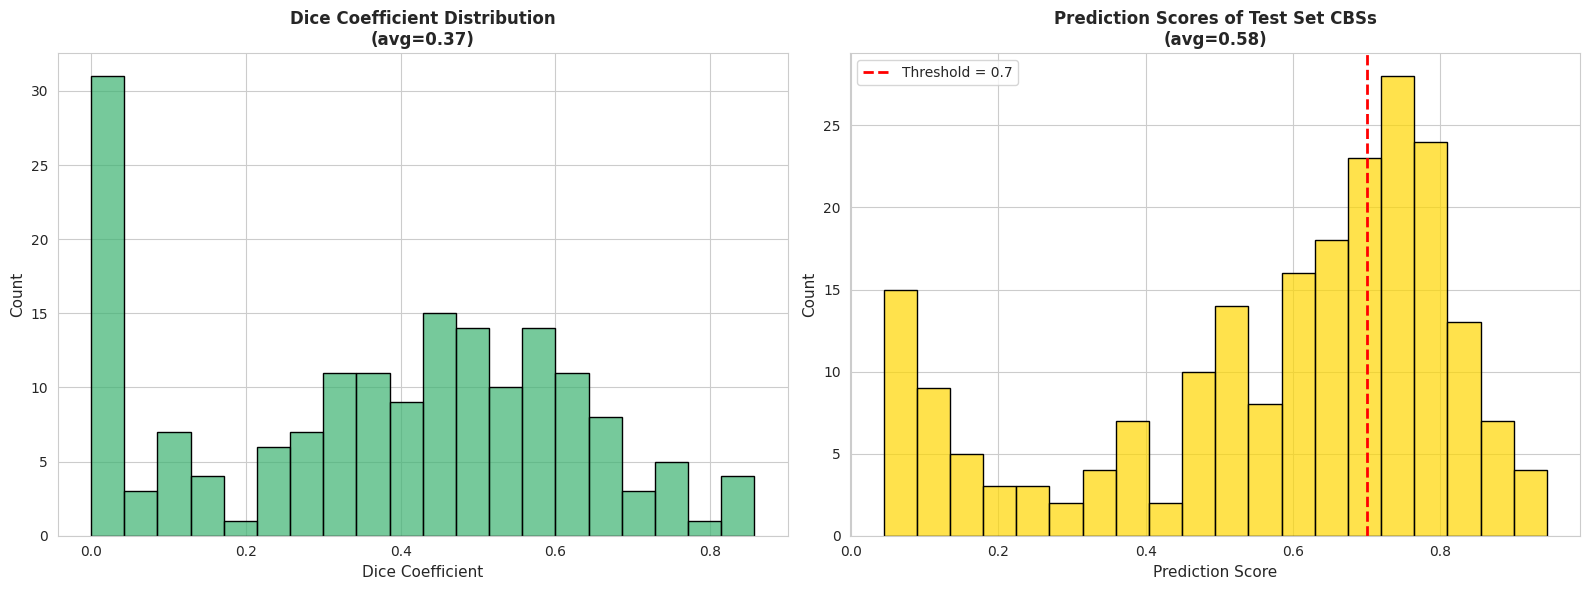

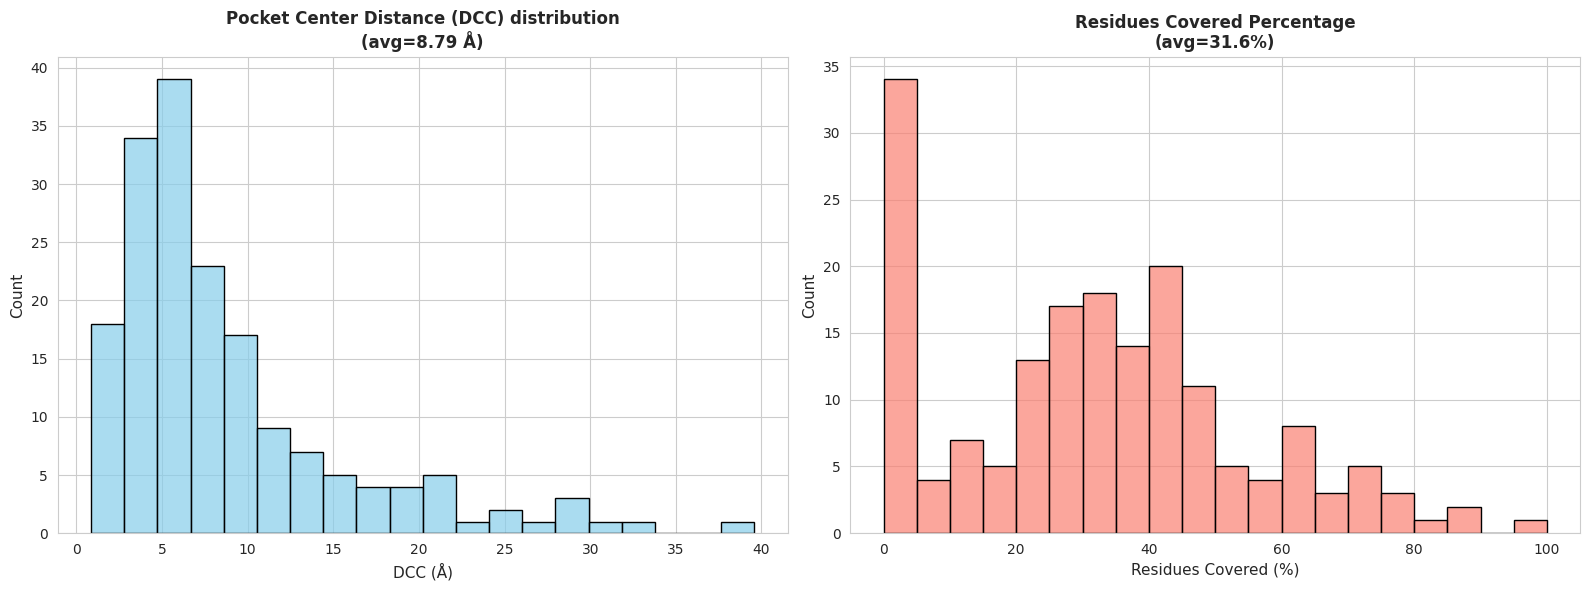

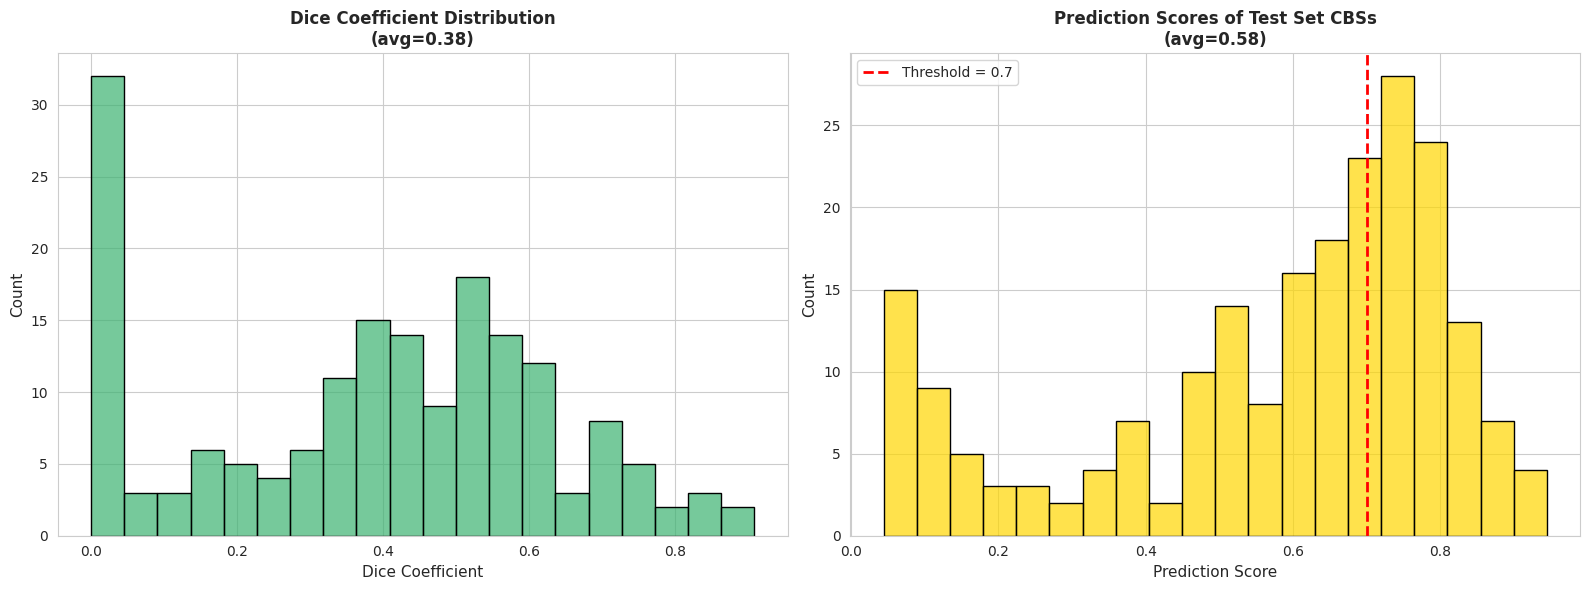

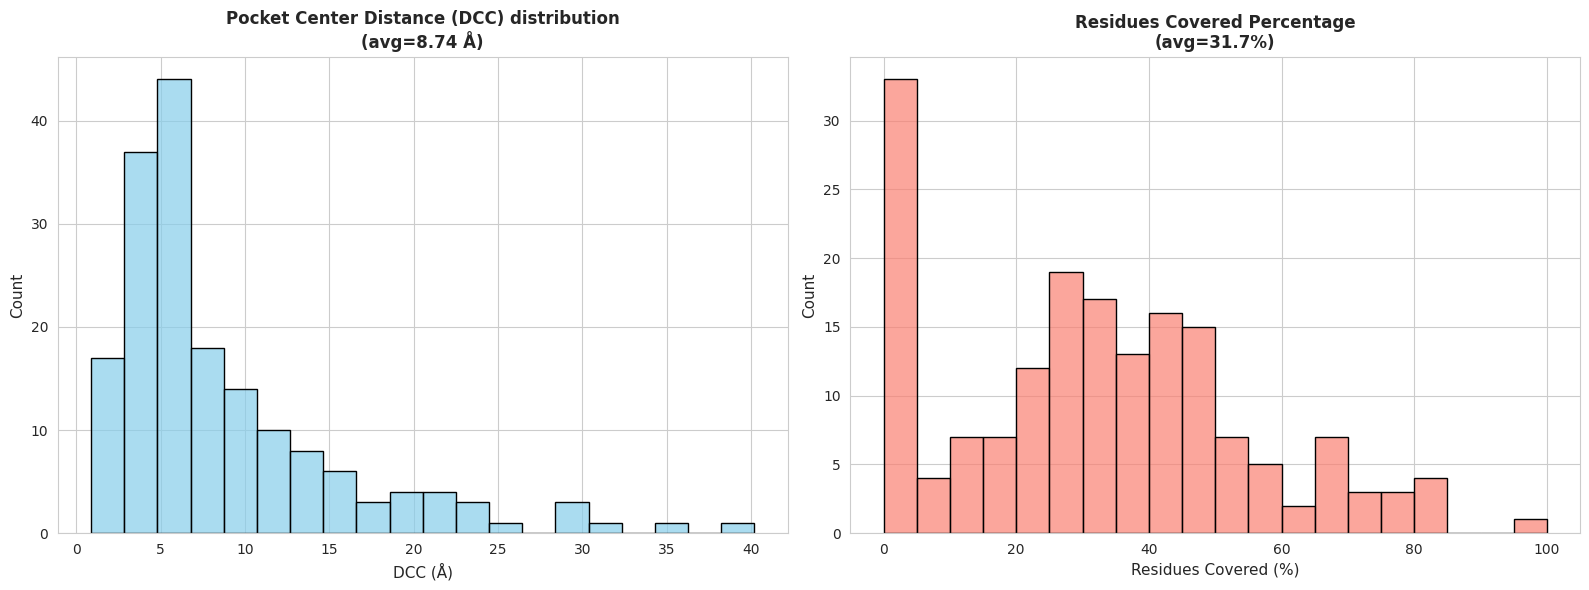

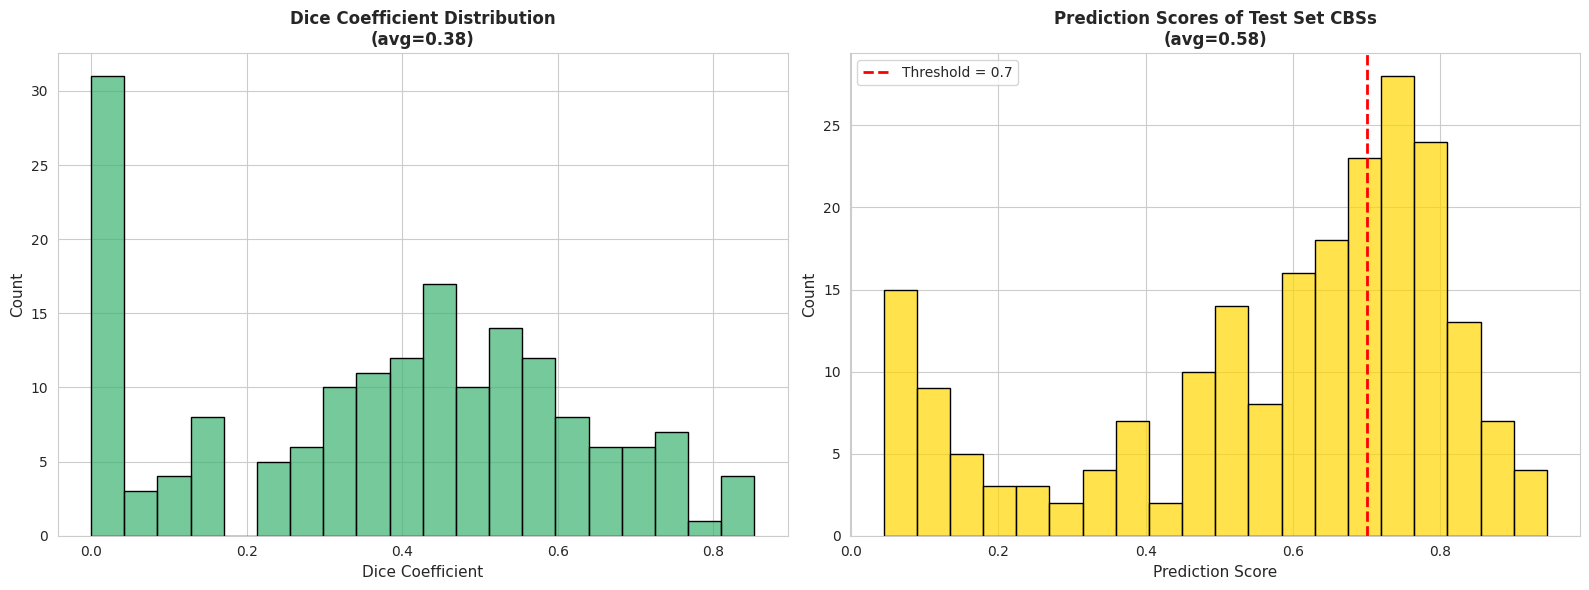

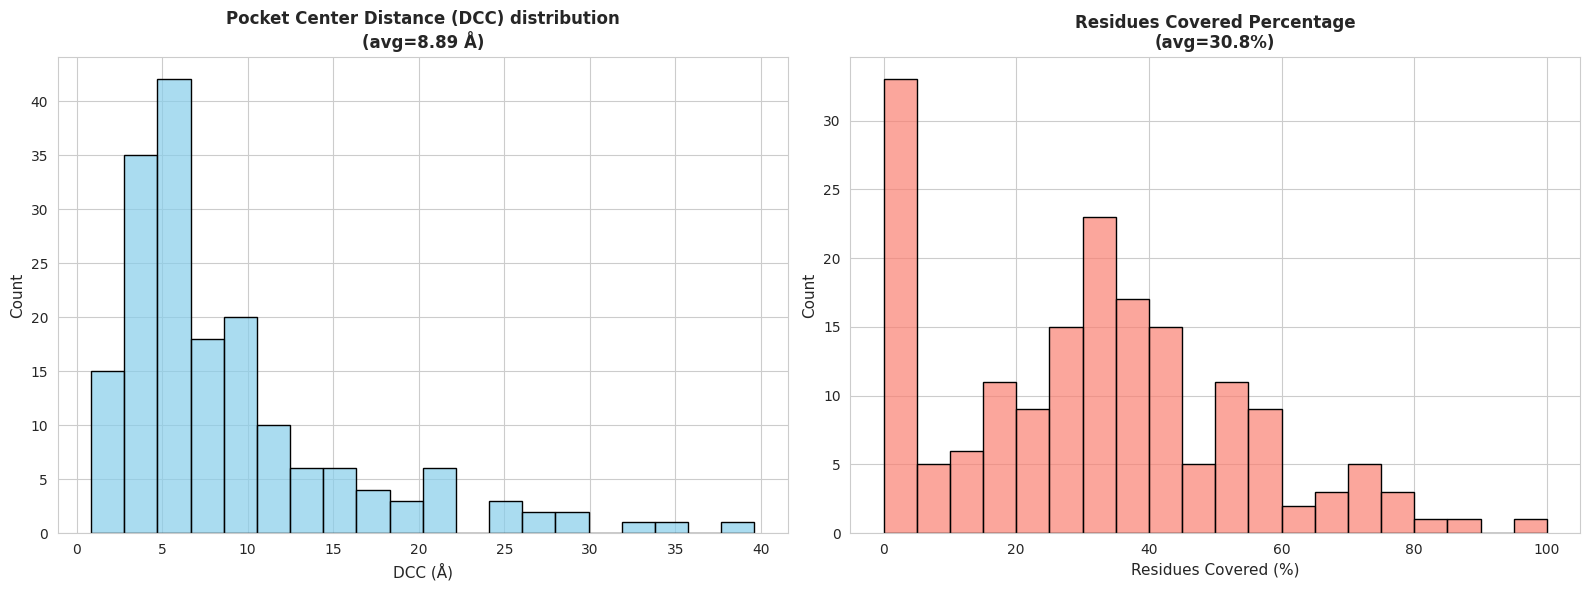

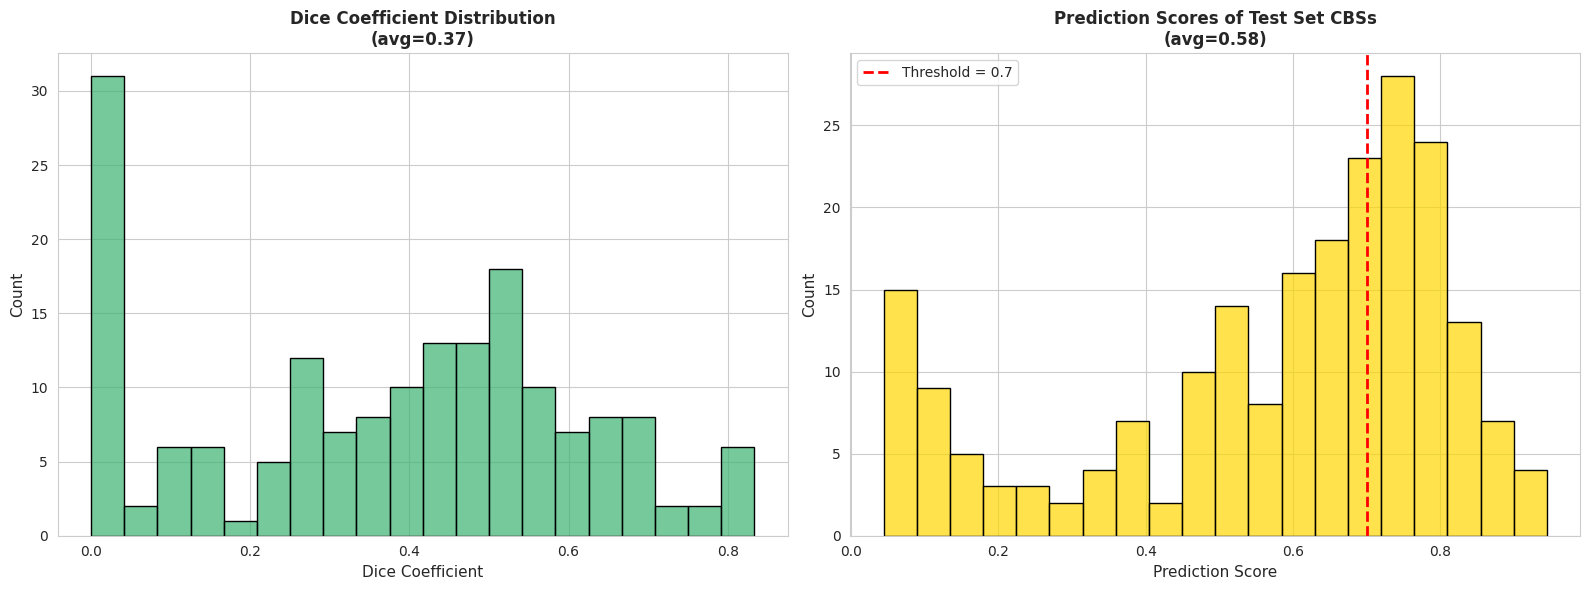

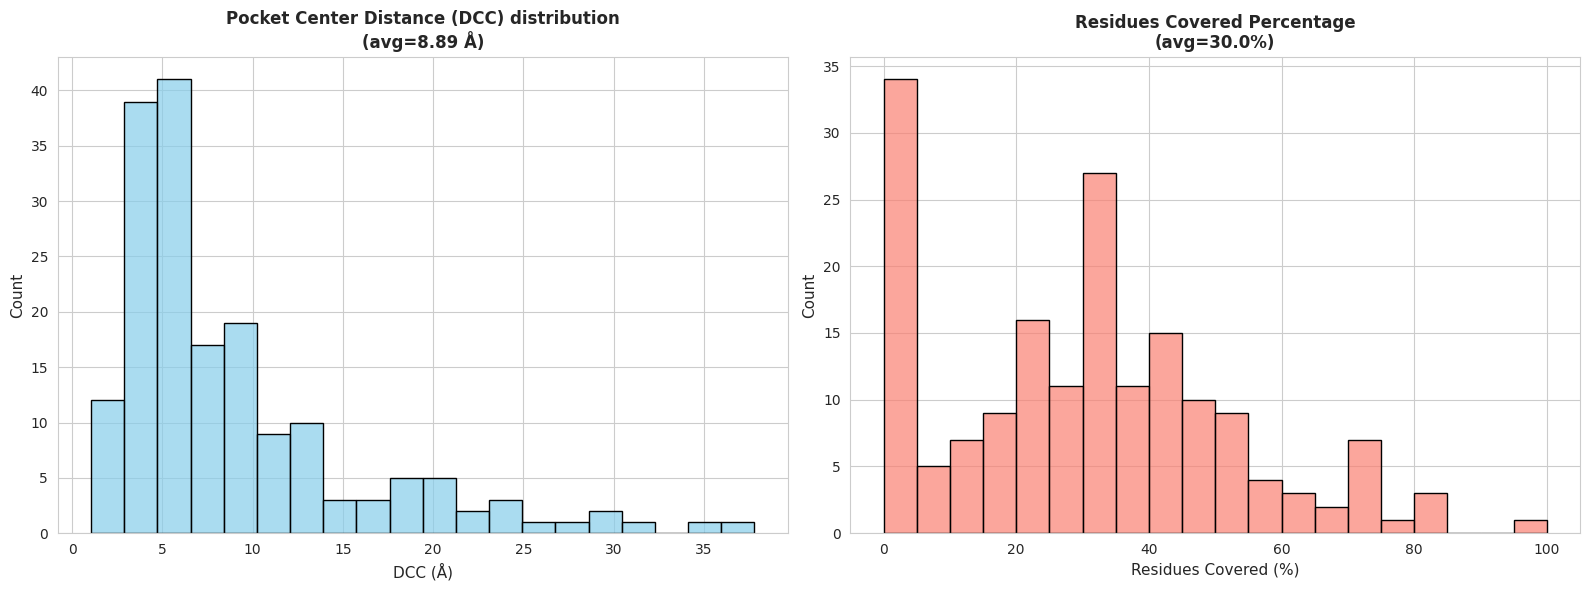

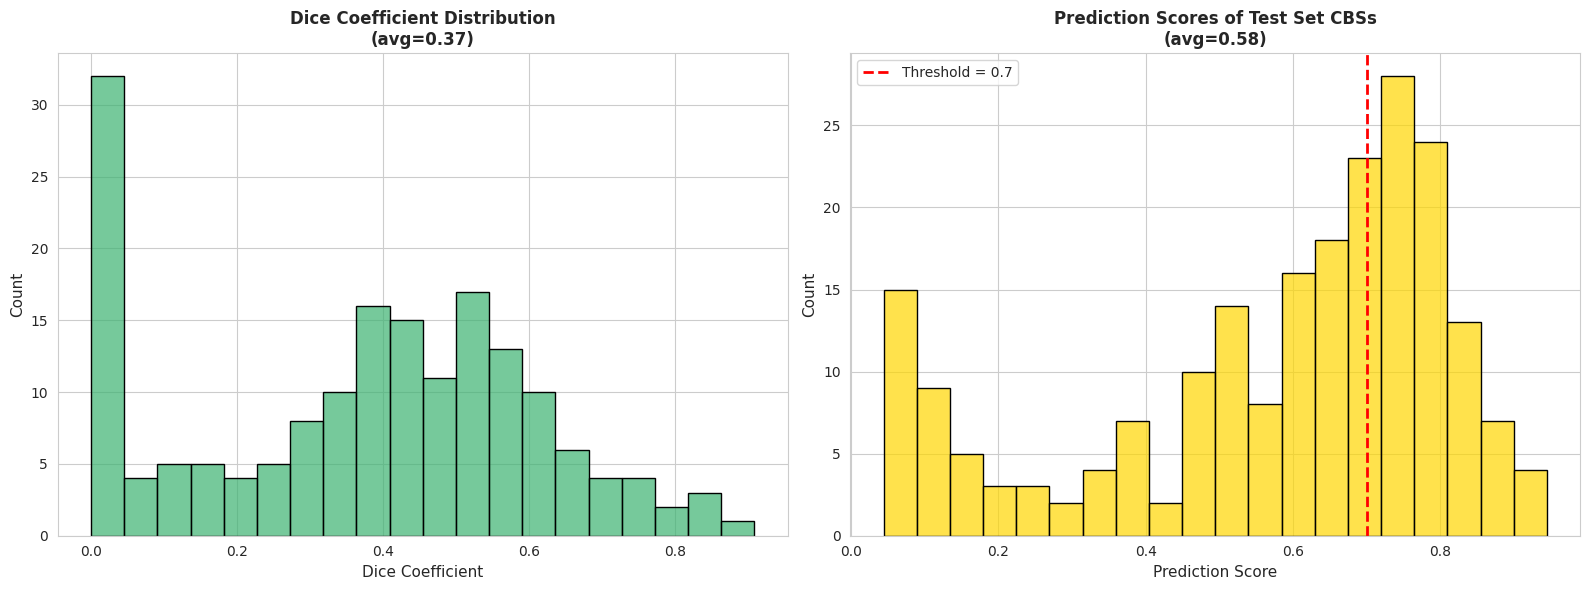

In [ ]:
os.makedirs("./tmp", exist_ok=True)

refined_clusters = {}
prediction_scores = {}
structure_coords = {}

DEBUG = False

for smoothened_threshold in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
    run_pocket_level_evaluation(smoothened_threshold=smoothened_threshold)

# Try pocket-level evaluation without smoothing
Run the same pipeline; however, now without the smoothing classifier. See whether the results worsen.

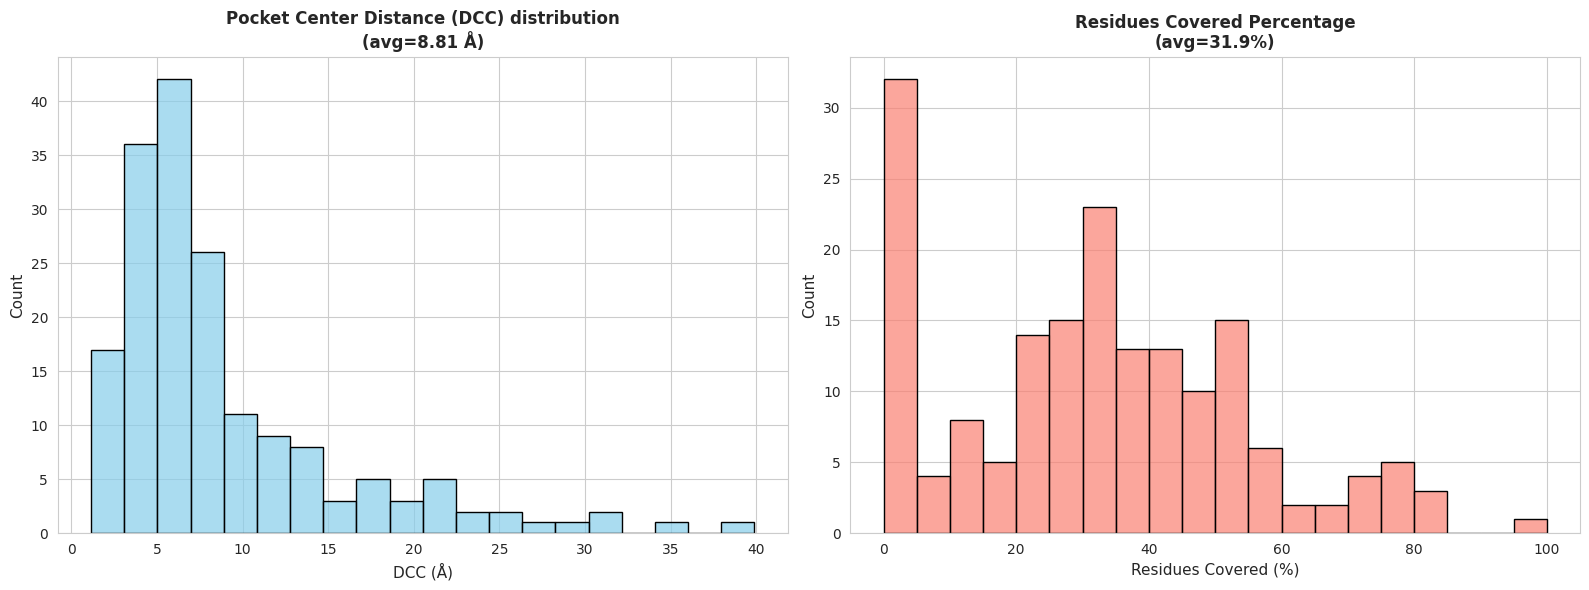

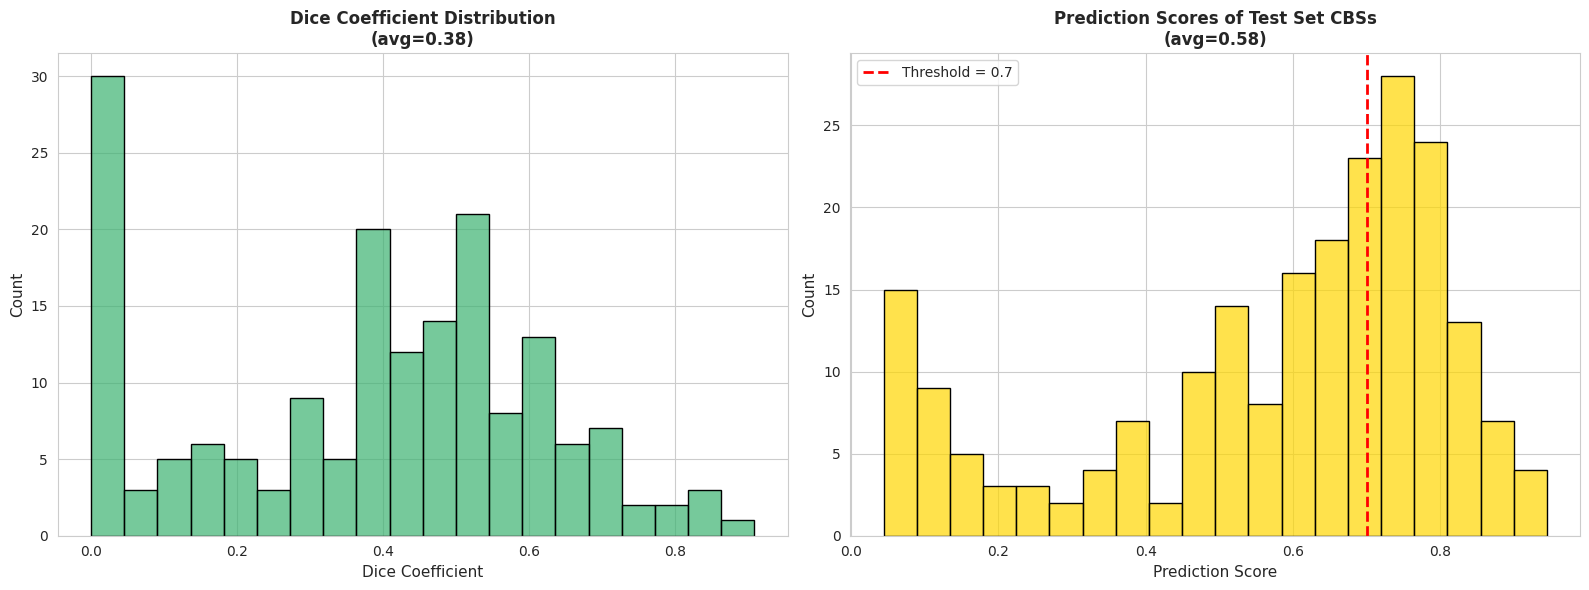

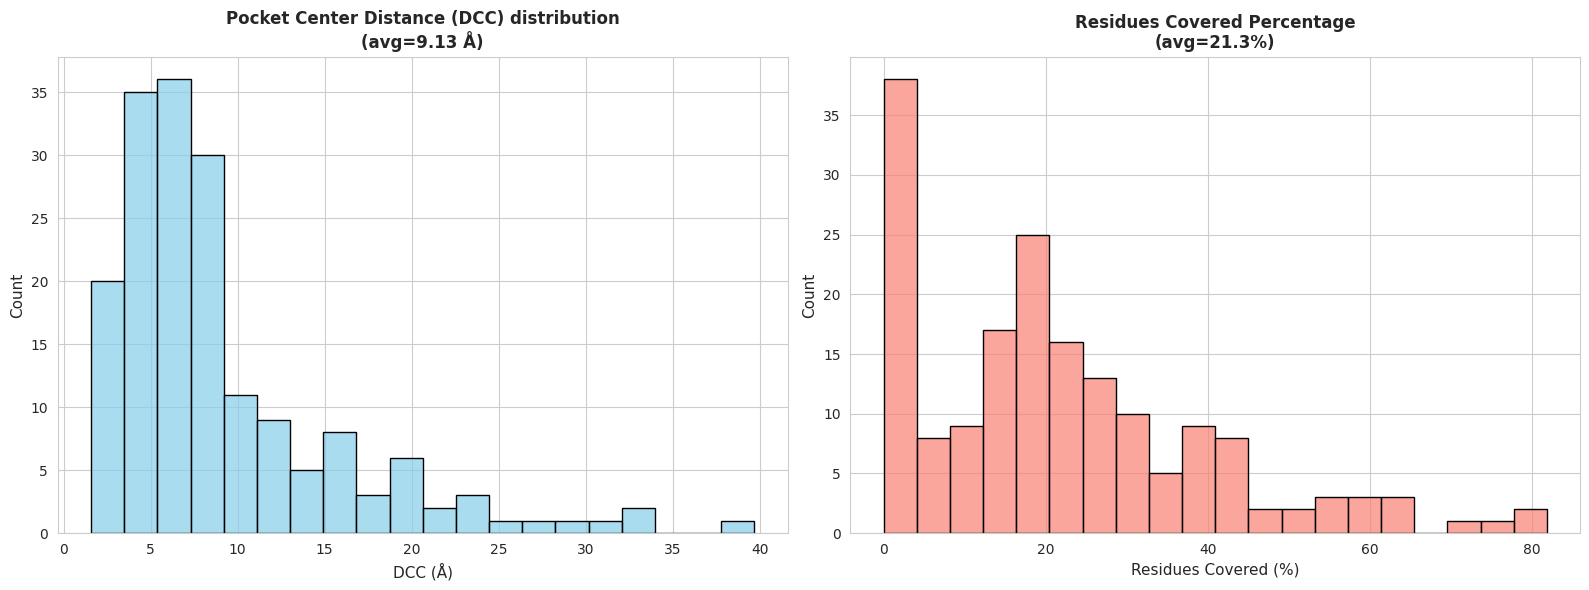

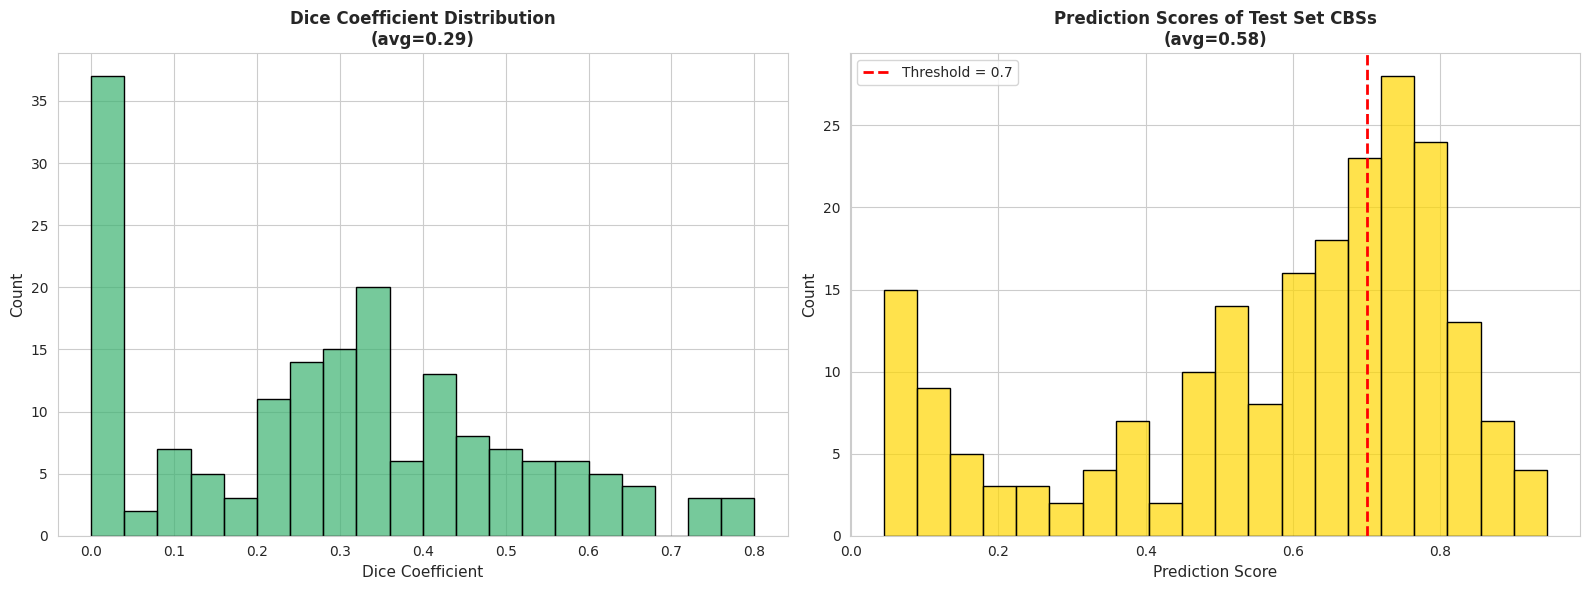

In [ ]:
os.makedirs("./tmp", exist_ok=True)

refined_clusters = {}
prediction_scores = {}
structure_coords = {}

# run with smoothing
run_pocket_level_evaluation()
# run without smoothing
run_pocket_level_evaluation(smoothened_threshold=1.1, pocket_distance_xlim=50, residues_covered_xlim=40) # 1.1 value of smoothened_threshold disables smoothing